# Heart Failure Survival Analysis & Mortality Prediction Modelling 

## Import Data & Dataset Overview

In [1]:
import pandas as pd
import numpy as np
import os

url='https://raw.githubusercontent.com/ErezWasserman/Heart-Failure-Prediction/main/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(url)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [3]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


#### Note: Features explanation and units/measurements can be found [here](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1).

## EDA & Data Visualization

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

### Categorical features distribution (grouped by target)

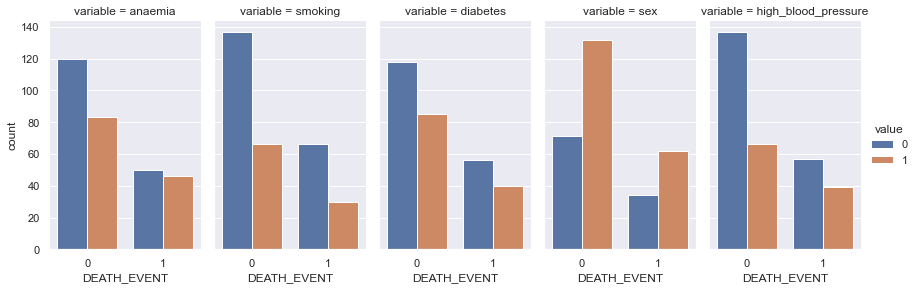

In [52]:
category_features = ['anaemia', 'smoking', 'diabetes', 'sex', 'high_blood_pressure']
binary_df = data[category_features].copy()
binary_df['DEATH_EVENT'] = data['DEATH_EVENT']
binary_df = binary_df.melt(id_vars=['DEATH_EVENT'])

g = sns.catplot(x='DEATH_EVENT', hue='value', col='variable', col_wrap=5,
                data=binary_df, kind="count", height=4, aspect=.6)

### Correlation between categorical features and target

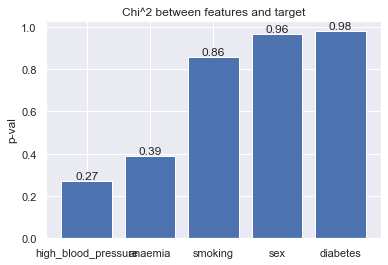

In [53]:
from sklearn.feature_selection import chi2

X = data[category_features] 
y = data['DEATH_EVENT'] 
chi_scores = chi2(X,y)

tups = sorted(zip(chi_scores[1],X.columns))
ordered_y,oredered_x = map(list,zip(*tups))
plot = plt.bar(oredered_x, ordered_y)  # X.columns, chi_scores[1]

# print p-values on top
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,'%.2f' % height, ha='center', va='bottom')

plt.title("Chi^2 between features and target")
plt.ylabel("p-val")
plt.show();

### Quantitative features distribution (grouped by target)

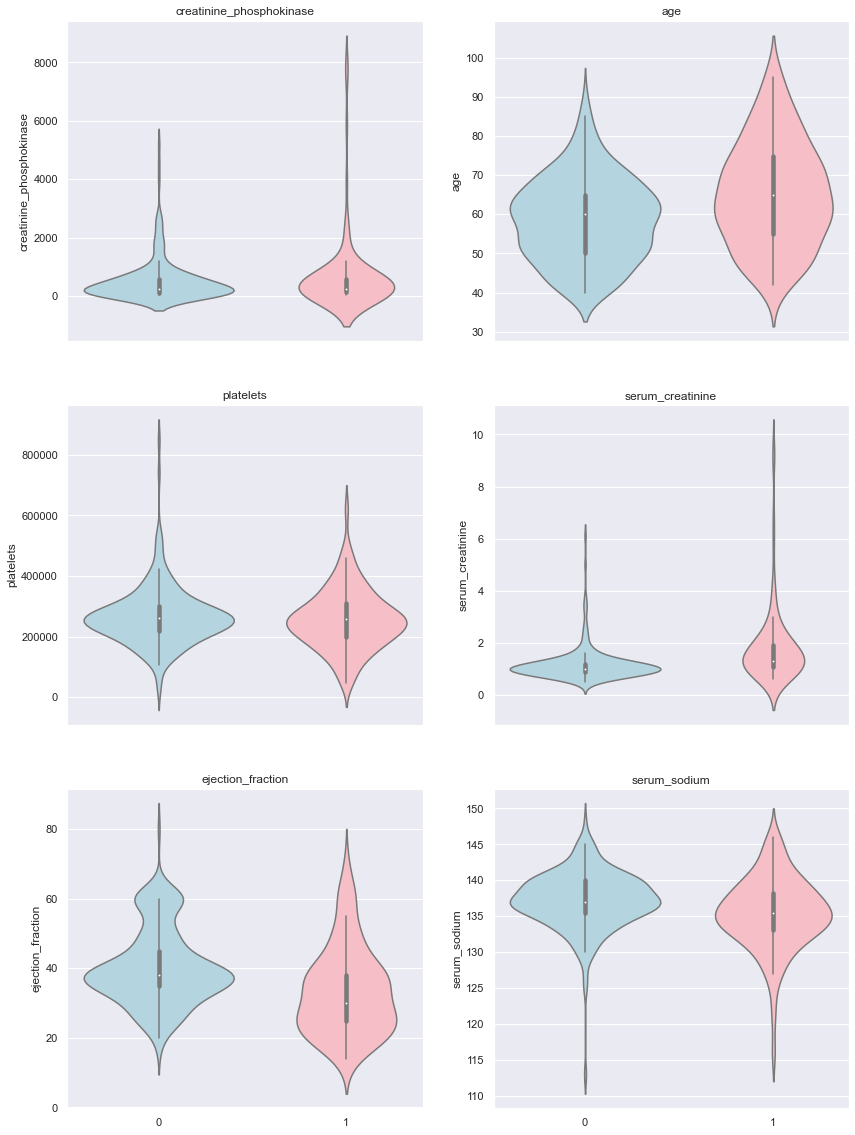

In [54]:
headers = list(data.keys())
target_features = ['time', 'DEATH_EVENT']


def set_approach(a,b):
    return list(set(a)-set(b))

numeric_features = set_approach(headers, target_features + category_features)

fig, axes = plt.subplots(round((len(numeric_features))/2),2, figsize=(14,20), sharex="col")

for i, j in enumerate(numeric_features):
    row = int(i/2)
    col = int(i%2)
    
    sns.violinplot(x="DEATH_EVENT", y=j, data=data, palette=["lightblue", "lightpink"], order=[0, 1], ax=axes[row, col])
    axes[row,col].set_xlabel('')
    axes[row,col].autoscale()
    axes[row,col].set_title(j)
plt.show()

### Correlation between quantitative features and target

Most correlated features:

serum_creatinine     0.294278
ejection_fraction   -0.268603
age                  0.253729
Name: DEATH_EVENT, dtype: float64


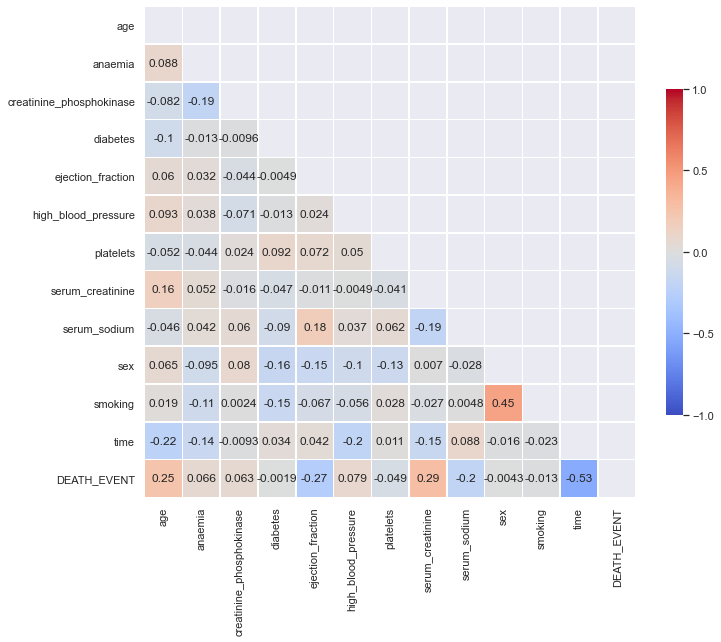

In [55]:
corr_matrix = data.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# Finding 3 topmost features correlated with 'DEATH_EVENT' ('time' excluded) 
most_corr = corr_matrix[['DEATH_EVENT']].abs().nlargest(5, 'DEATH_EVENT', keep='all')[-3:].index.tolist()
print('Most correlated features:\n\n{}'.format(corr_matrix['DEATH_EVENT'][most_corr]))

## Survival Analysis

### Events vs. Censored distributions

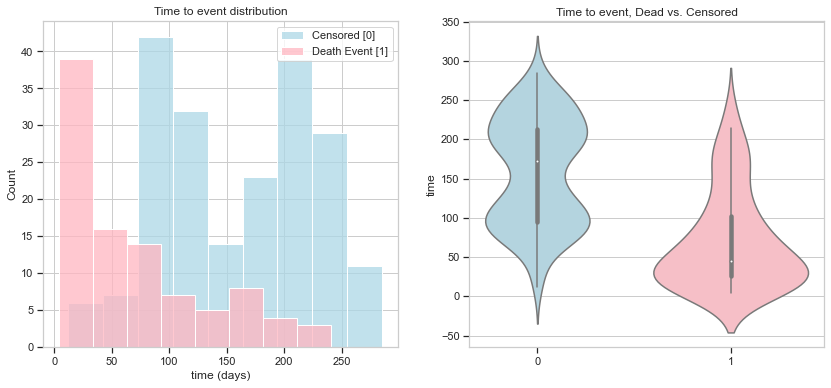

In [56]:
fig, axes = plt.subplots(1,2, figsize=(14,6)) 

sns.histplot(data.query("DEATH_EVENT==0")['time'], color="lightblue", label="Censored [0]",ax=axes[0])
sns.histplot(data.query("DEATH_EVENT==1")['time'], color="lightpink", label="Death Event [1]",ax=axes[0])
axes[0].legend()
axes[0].set_xlabel('time (days)')
axes[0].set_title('Time to event distribution')
axes[0].autoscale()

sns.violinplot(x="DEATH_EVENT", y='time', data=data, palette=["lightblue", "lightpink"], order=[0, 1], ax=axes[1])
axes[1].set_xlabel('')
axes[1].autoscale()
axes[1].set_title('Time to event, Dead vs. Censored')

plt.show()

### Plot life-lines of individuals

For less visual clutter, you may want to subsample to less than 25 individuals.


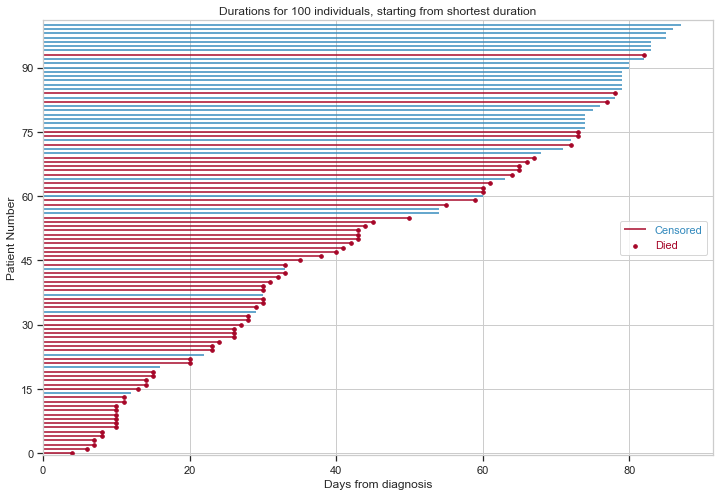

In [57]:
from lifelines.plotting import plot_lifetimes

T = data['time']
E = data['DEATH_EVENT']

plt.figure(figsize=(12,8))
plt.ylabel("Patient Number")
plt.xlabel("Days from diagnosis")
plt.title('Durations for 100 individuals, starting from shortest duration')
ax = plot_lifetimes(T.loc[:100], event_observed=E.loc[:100])
ax.legend(['Censored', 'Died'], loc=7, labelcolor=['#348ABD', '#A60628']);

###  Survival Curve Estimations using Kaplan-Meier Estimate <br><br>  $\hat{S}(t)$ $=$ $\prod_{i: t_i \le t}$ $\frac{n_i - d_i}{n_i}$ 

#### Where: <br> ${n_i}$ - the number of people at risk at time just prior to time ${t_i}$ <bR> ${d_i}$ - the number of events occurred at time ${t_i}$ 

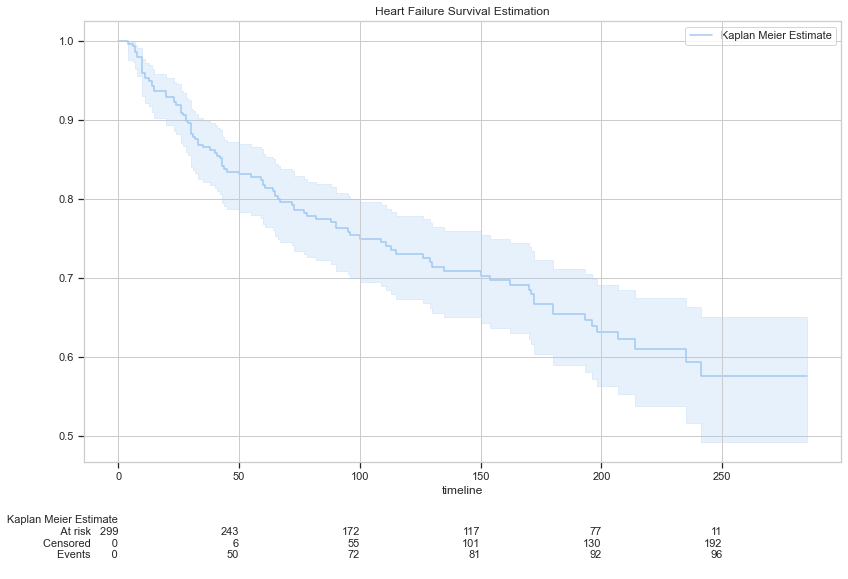

In [58]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Kaplan Meier Estimate')

plt.figure(figsize=(12,8))
kmf.plot_survival_function(at_risk_counts=True)  
plt.title('Heart Failure Survival Estimation');

In [59]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,299,299
4.0,1,1,0,0,299
6.0,1,1,0,0,298
7.0,2,2,0,0,297
8.0,2,2,0,0,295
...,...,...,...,...,...
270.0,2,0,2,0,6
271.0,1,0,1,0,4
278.0,1,0,1,0,3


In [60]:
kmf.survival_function_

,Kaplan Meier Estimate
timeline,
0.0,1.000000
4.0,0.996656
6.0,0.993311
7.0,0.986622
8.0,0.979933
...,...
270.0,0.575705
271.0,0.575705
278.0,0.575705


In [61]:
kmf.predict(6)  # fraction of people who survived (x) days or above

0.9933110367892974

### Cumulative Density Curve Estimations using Kaplan-Meier Estimate <br> <br> $\hat{F}(t) = 1 - \hat{S}(t)$

The probability of a person dying within a certain period of time

          Kaplan Meier Estimate
timeline                       
0.0                    0.000000
4.0                    0.003344
6.0                    0.006689
7.0                    0.013378
8.0                    0.020067


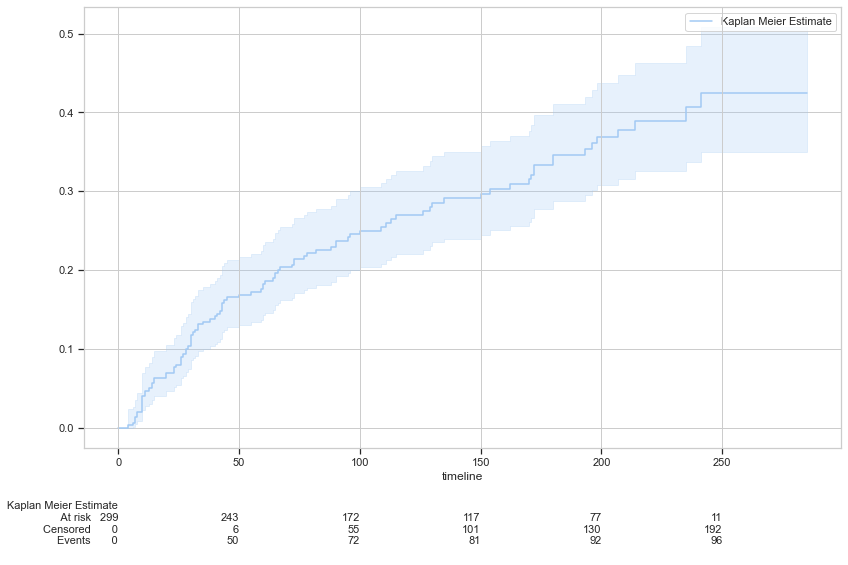

In [62]:
print(kmf.cumulative_density_.head())

plt.figure(figsize=(12,8))
kmf.plot_cumulative_density(at_risk_counts=True);

### Comparing Cohort's Survival Curves Estimations & Log-rank tests

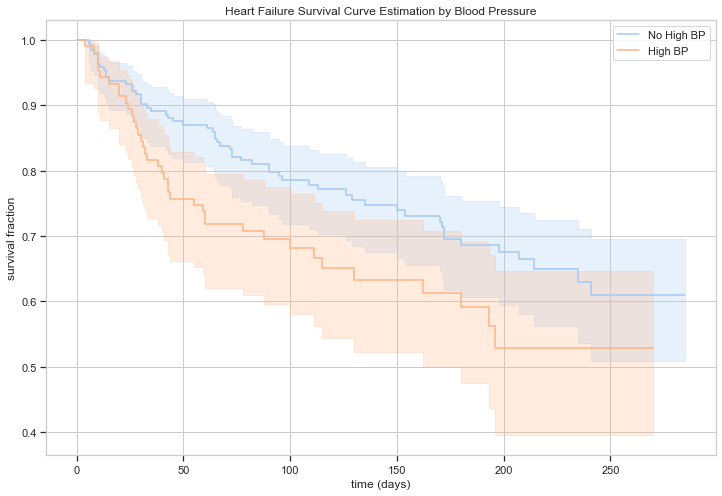

In [63]:
# Example for one binary feature: High Blood Pressure 

kmf1 = KaplanMeierFitter()
feat = (data['high_blood_pressure'] == 0)
plt.figure(figsize=(12,8))

kmf1.fit(T[feat], event_observed=E[feat], label='No High BP')
ax = kmf1.plot()

kmf1.fit(T[~feat], event_observed=E[~feat], label='High BP')
kmf1.plot(ax=ax)

plt.xlabel('time (days)')
plt.ylabel('survival fraction')
plt.title('Heart Failure Survival Curve Estimation by Blood Pressure');

In [64]:
# Log-Rank test to compare survival distributions of the 2 cohorts
from lifelines.statistics import logrank_test

results = logrank_test(T[feat], T[~feat], E[feat], E[~feat], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.41 0.04      4.80

,feature,statistic,p_value
0,anaemia,2.73,0.10
1,smoking,0.00,0.96
2,diabetes,0.04,0.84
3,sex,0.00,0.95
4,high_blood_pressure,4.41,0.04


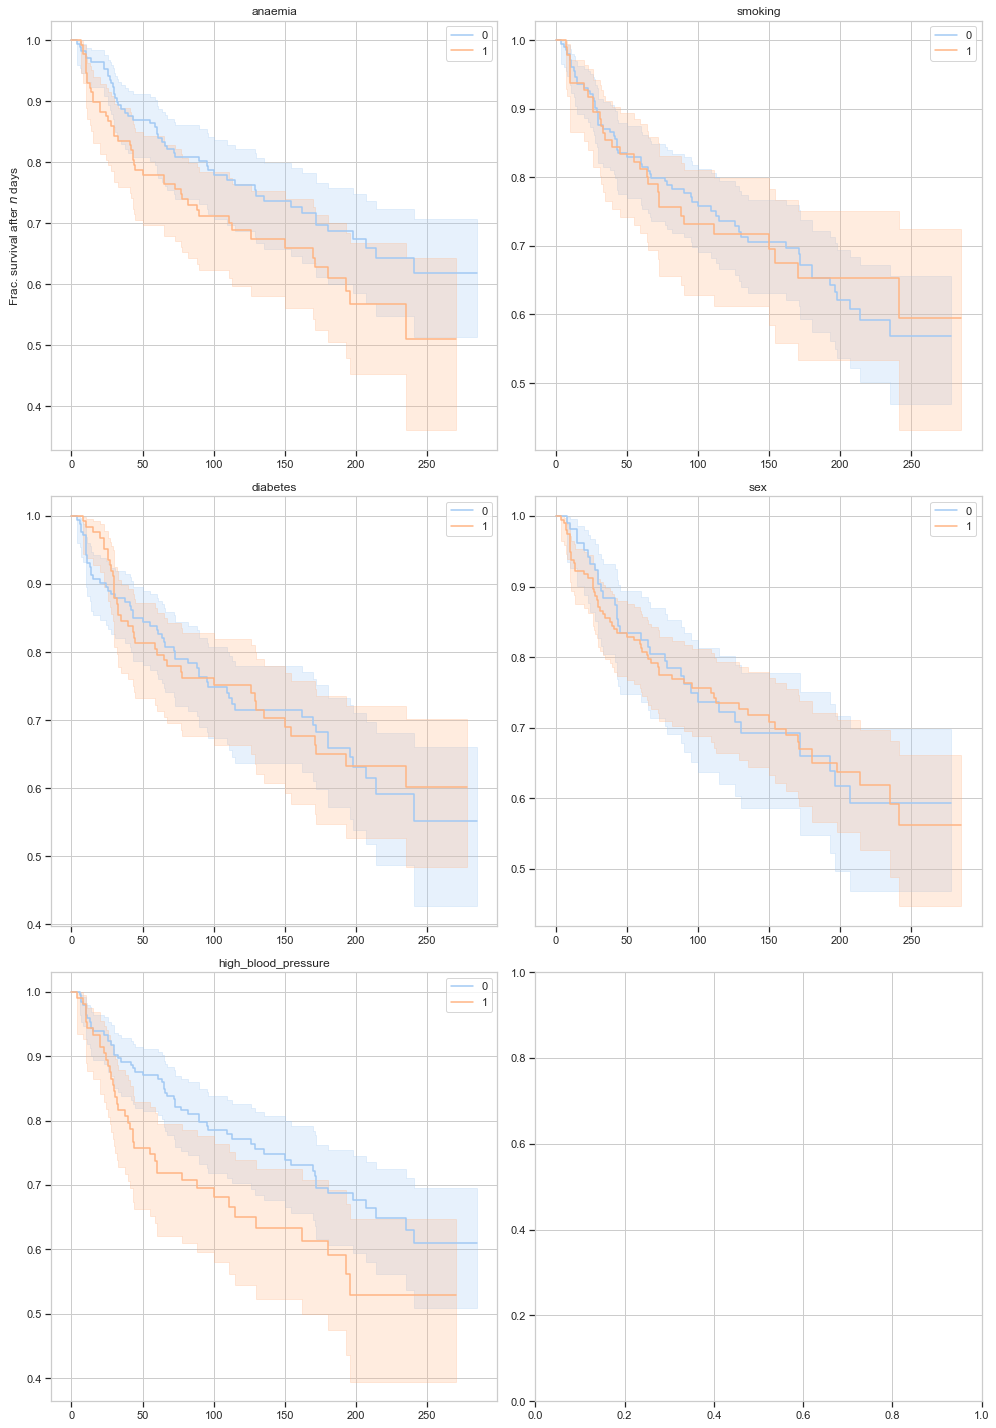

In [65]:
# Comparing every binomial features (0: No, 1: Yes) 

compared_feat = ['anaemia', 'smoking', 'diabetes', 'sex', 'high_blood_pressure']
kmf1 = KaplanMeierFitter()

fig, axes = plt.subplots(3,2, figsize=(14,20), sharex="col")  # sharey="row"

log_rank_list = [] 
for i, feature in enumerate(compared_feat):
    ax = plt.subplot(3, 2, i + 1)

    ix = data[feature] == 0
    kmf1.fit(T[ix], event_observed=E[ix], label='0')
    kmf1.plot_survival_function(ax=ax)  # , legend=False
    
    kmf1.fit(T[~ix], event_observed=E[~ix], label='1')
    kmf1.plot(ax=ax)
 
    plt.title(feature)
    plt.xlabel('')
    plt.autoscale()

    if i==0:
        plt.ylabel('Frac. survival after $n$ days')
        
    results = logrank_test(T[ix], T[~ix], E[ix], E[~ix]) 
    dict1 = {}
    dict1.update(feature = feature, statistic = '%.2f' % results.test_statistic, p_value = '%.2f' % results.p_value)
    log_rank_list.append(dict1)

plt.tight_layout()
df = pd.DataFrame(log_rank_list)
df

### Hazard Rates Estimations using Nelson-Aalen Estimate <br> <br> $\hat{H}(t)$ $=$ $\sum_{t_i \le t}$ $\frac{d_i}{n_i}$

#### Where: <br> ${n_i}$ - the number of people at risk at time just prior to time ${t_i}$ <bR> ${d_i}$ - the number of events occurred at time ${t_i}$

          NA_estimate
timeline             
0.0          0.000000
4.0          0.003344
6.0          0.006700
7.0          0.013446
8.0          0.020237


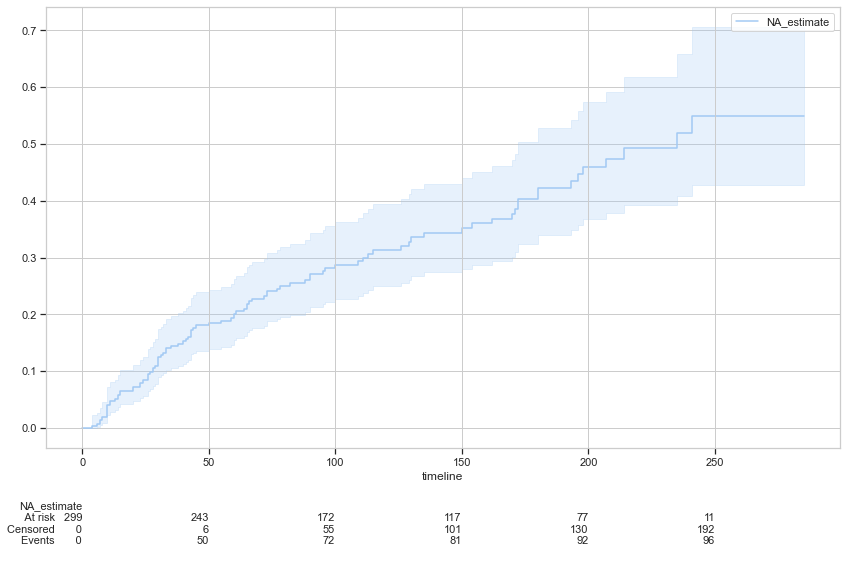

In [66]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T, event_observed=E)

print(naf.cumulative_hazard_.head())
plt.figure(figsize=(12,8))
naf.plot_cumulative_hazard(at_risk_counts=True);

### Cox Proportional Hazard Model (Survival Regression) <br> <br> $h(t|X=x) = h_0(t)\exp(x^T\beta)$

#### Where: <br> ${h_0(t)}$ - the baseline hazard function <br> ${x}$ - the covariates' value vector <bR> ${\beta}$ - the covariates' coefficient vector

The Cox Model is commonly used in cases where we want to take into account and calculate the impact of additional covariates (features) on the survival curve of individuals 

In [67]:
from lifelines import CoxPHFitter
data_r = data.loc[:,['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']]
data_r.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [68]:
# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()   
cph.fit(data_r, 'time', event_col='DEATH_EVENT')   
cph.print_summary()   

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2021-02-25 09:25:37 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                        0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia                    0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
creatinine_phosphokinase   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes                   0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
ejection_fraction         -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure        0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine           0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium              -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                       -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking                    0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                             z      p   -log2(p)
covariate                                       
age                       4.98 <0.005      20.56
anaemia                   2.12   0.03       4.89
creatinine_phosphokinase  2.23   0.03       5.26
diabetes                  0.63   0.53       0.91
ejection_fraction        -4.67 <0.005      18.35
high_blood_pressure       2.20   0.03       5.17
platelets                -0.41   0.68       0.56
serum_creatinine          4.58 <0.005      17.68
serum_sodium             -1.90   0.06       4.12
sex                      -0.94   0.35       1.53
smoking                   0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

#### Plotting the coefficient value ( $\beta$ $\pm$  95% CI) of each covariate

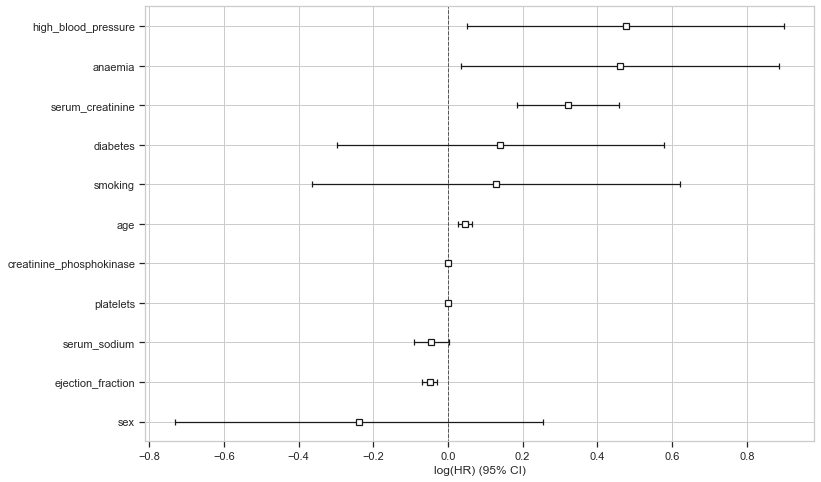

In [69]:
plt.figure(figsize=(12,8))
cph.plot();

#### Predicting Survival of individual patients based on their specific measures

In [70]:
tr_rows = data_r.iloc[5:10, 0:-2]
tr_rows

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1


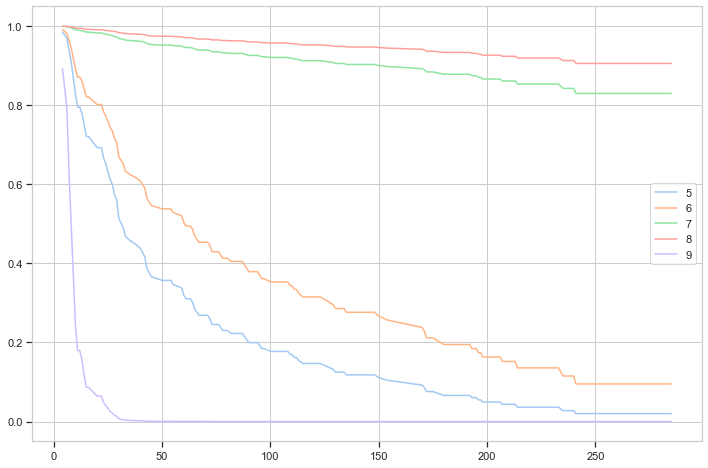

In [71]:
cph.predict_survival_function(tr_rows).plot(figsize=(12,8));

#### Visualizing predicted survival curves for new patients based on the fitted Cox model

In [72]:
# %matplotlib notebook
from ipywidgets import *  # from ipywidgets import widgets, interact
from IPython.display import display
from IPython.html import widgets
# plt.style.use('ggplot')

# features metadata for generating widgets
checkbox_features = ['anemia', 'diabetes', 'high_blood_pressure', 'smoking']
floatslider_features = [['cpk', 'creatinine phosphokinase (mcg/L)',20,8000,0.1], 
                        ['eject_frac', 'ejection fraction (%)',10,90,1], 
                        ['platelets', 'platelets (kiloplatelets/mL)',20,900,0.01], 
                        ['ser_creat', 'serum creatinine (mg/dL)',0.4,20,0.1], 
                        ['ser_sod', 'serum sodium (mEq/L)',110,150,1]]

def count_decimals(num):
    try:
        decimals = len(str(num).split('.')[1])
    except:
        decimals = 0
    readout_format = '.{}f'.format(decimals)
    return readout_format


def create_floatslider(feature_details):
    floatslider_dict[feature_details[0]] = widgets.FloatSlider(
        value=feature_details[2] + ( (feature_details[3] - feature_details[2]) / 2), # 7.5,
        min=feature_details[2],  #100,
        max=feature_details[3],  #1000,
        step=feature_details[4],  #0.1,
        description=feature_details[1],  #'Blood Creatinine:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format=count_decimals(feature_details[4])  # '.1f',
    )
    display(floatslider_dict[feature_details[0]])

    
def create_checkbox(feature_details):
    checkbox_dict[feature_details] = widgets.Checkbox(
        value=False,
        description=feature_details,
        disabled=False,
        indent=False
    )
    display(checkbox_dict[feature_details])

Text(value='John Doe', description='Patient Identifier:', placeholder='Type here')

Dropdown(description='Sex:', options=(('Male', 1), ('Female', 0)), value=1)

BoundedIntText(value=55, description='Age (yrs):', max=119, min=40)

Checkbox(value=False, description='anemia', indent=False)

Checkbox(value=False, description='diabetes', indent=False)

Checkbox(value=False, description='high_blood_pressure', indent=False)

Checkbox(value=False, description='smoking', indent=False)

FloatSlider(value=4010.0, continuous_update=False, description='creatinine phosphokinase (mcg/L)', max=8000.0,…

FloatSlider(value=50.0, continuous_update=False, description='ejection fraction (%)', max=90.0, min=10.0, read…

FloatSlider(value=460.0, continuous_update=False, description='platelets (kiloplatelets/mL)', max=900.0, min=2…

FloatSlider(value=10.200000000000001, continuous_update=False, description='serum creatinine (mg/dL)', max=20.…

FloatSlider(value=130.0, continuous_update=False, description='serum sodium (mEq/L)', max=150.0, min=110.0, re…

Button(description='Predict Survival Curve', style=ButtonStyle())

Output()

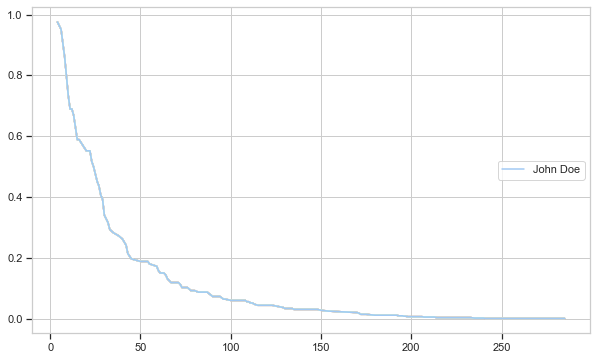

In [73]:
pat_id = widgets.Text(
    value='John Doe',
    placeholder='Type here',
    description='Patient Identifier:',
    disabled=False
)
display(pat_id)

sex = widgets.Dropdown(
    options=[('Male', 1), ('Female', 0)],
    value=1,
    description='Sex:',
)
display(sex)

age = widgets.BoundedIntText(
    value=55,
    min=40,
    max=119,
    step=1,
    description='Age (yrs):',
    disabled=False
)
display(age)

checkbox_dict = {}
for feature_details in checkbox_features:
    create_checkbox(feature_details)

floatslider_dict = {}
for feature_details in floatslider_features:
    create_floatslider(feature_details)
    
button = widgets.Button(description="Predict Survival Curve")
output = widgets.Output()
display(button, output)

def on_button_clicked(b):
    patient_features = np.array([age.value, int(checkbox_dict['anemia'].value), floatslider_dict['cpk'].value, \
int(checkbox_dict['diabetes'].value), floatslider_dict['eject_frac'].value, int(checkbox_dict['high_blood_pressure'].value), \
floatslider_dict['platelets'].value, floatslider_dict['ser_creat'].value, floatslider_dict['ser_sod'].value, sex.value, \
int(checkbox_dict['smoking'].value)])
    ax = cph.predict_survival_function(patient_features).plot(figsize=(10,6)) # , legend=False
    ax.legend([pat_id.value], loc=7); # , labelcolor=['#348ABD'] # , '#A60628'
    with output:
        print("Button clicked.")
    
button.on_click(on_button_clicked)

## Implementing machine learning regression models for survival prediction:

## XGBoost (eXtreme Gradient Boosting) for survival analysis

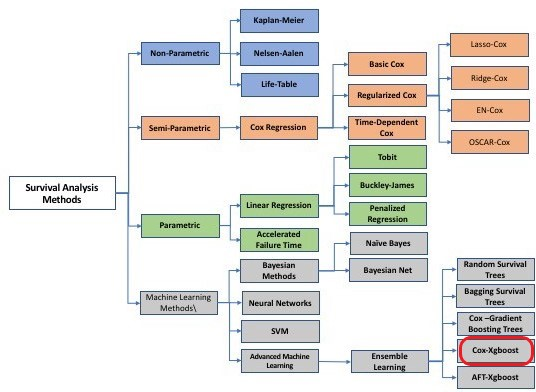

In [74]:
from IPython import display 
from base64 import b64decode 
base64_data="/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAGIAhgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikbpQAtFRc7fX2pG+VWPtQLpckyO9G4dzX5/+D9Q1nVfCmi3t34q8VTXVxZQSyyHxLfjLtGpJIE+Mkk+nUACthjqf/Q0eK//AAptR/8Aj1e9HKKsldSR5rx0btWPunijivhbdqX/AEM/ir/wptR/+PUb9S/6GbxV/wCFNqP/AMep/wBj1v5kL69H+Vn3TxRxXwt5mp/9DR4r/wDCm1H/AOPUm7Uv+ho8V/8AhTaj/wDHqP7HrfzIPr0f5WfdO6jd718LbtS/6GjxX/4U2o//AB6jdqX/AENHiv8A8KbUf/j1H9j1v5kH1+PY+6cjsaMjtXwvu1Pr/wAJP4r/APCm1H/49Umm6lq+meJPC80XibxI5bXdLhdZtfvZo5I5L6BHVkeVlZWViDuHQ1M8oqwi5trQax0W0rH3NRSUteEemFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUjfdNLSUAct448RXfhXQ0urOzj1C6mu7azigmnMCM80yRAs4RiAC+chSeK4fxn4i+LFp/Zf9j+FNBmMl2EuVTV5Jh5O1ixYtBEEAOPmBY5wAjZ46v4qf8gPSv+w9pP8A6XQV2Mn+rb6VvCShyvlT9TmqRc7rma9D4A8Bgf8ACDeHgGLKNNtgpYYP+qXsSfx54rI+MUniCPwBdv4XEx1v7XZfZ/JDscG7iEm7aC2zZu3EdF3Z4rW+H/8AyInhz/sG2v8A6KFb1foMbSgtVqfObSufOF58UPH/AIR0PRki0jVbiWLTJrnWJtY0uVlW5C3JlPnqQgRJYk2rgL5bIVLBsqWnxE+IOpR2eutpupTwWsV55L2WjXMKThre0dS9qz7m2SyTorE5IjYru5B+jJoY7iGSKWNZYpFKvG4BVgRggg9QaWNFjRUUKqqMBVGBjsB2FYeyd/jZt7RW+FHhWhfET4o302jyz6EIrcG1jvIZtKniabffXVu7hy37oLDHBMcoceYDgKap+LtS+KK+PrxrCy1C3sdTtbbRxb2xa4ttOmm8wm9STYoIhEZ3YA5dQR0r6DopuleLXOxc6vflR8wWvjb4rr4Tk0qbRruRoPDuVe4tL4XtzN9k37xNGo2y+d8hQsr+nJXPWf8ACefFC+17VbGHS7bT4P7WWxglm0i6lMEBuWiE5JCxyqYQJMq/BOCAOF9zooVK1vfYcy/lQgzgZ69M9eev59fwPtmiL/kOeFv+xj0f/wBONvS0kX/Ic8Lf9jHo/wD6cbetazXspa9H+RlD416n3RS0lLX5wfWBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSN900ALRUfGODSZ6DOaWwrktFN5o5pjHUU3mjmgB1FN5o5oAdRTeaOaAHUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSN900AFFM7GvGf2kfFmveEdB8MnQNXm0S5v9ZFnNcwQwyv5QtLqXYBKjqMtEhyFzxitKVOVWcacd2ZzmoRcn0PaaK+Mv+FkfET/oomsf+AGm/wDyJS/8LI+IZ/5qJq//AIA6b/8AIlez/YuI7r8f8jh+v0+zPsvijivjP/hZPxF/6KJrH/gBpv8A8iUf8LK+In/RRNY/8AdN/wDkShZPiH1X4/5B9fp9mfZuaM18Zf8ACyPiJ/0UPV//AAA03/5Eo/4WR8RP+ih6x/4Aab/8iUf2NiP5l+P+Qvr9Psz7NzRmvjP/AIWT8RP+iiax/wCAGm//ACJR/wALJ+In/RRNY/8ABfpv/wAiUf2NiP5l+P8AkP6/S7M+zKTha+M/+FkfET/ooesf+AGm/wDyJXp37OfjbxP4m8UeLdO8Qa/ca9b2Vpp9xbtdW9tE0TSvdK4BhiQMCIk655Bxwa5sRltbDU/aTtY1p4uFSSik9T0n4qf8gLSv+w9pP/pdBXafwnvxXFfFT/kBaZ/2HdK/9LoK7ORsRtjrivOlrFWOhPWRwC/AP4ZqxB+HXhTnv/Ylt/8AEU//AIUH8Mu/w78Kf+CW2/8AiK+XvDHxY+JOteG9I1Cf4haos91ZwzuItP04KGZFY4BtjjqfoB3Nan/CyfiL/wBFD1f/AMANN/8AkSvcjleKkk1Jfe/8jgeKop2cfwR9Hf8ACgvhn/0Tvwr/AOCW2/8AiKP+FBfDL/onfhX/AMEtt/8AEV85f8LK+In/AEUTV/8AwA03/wCRKT/hZXxF/wCiiav/AOAGm/8AyJVf2Tiv5197/wAhfXKP8v4H0d/woP4Zf9E78K/+CW2/+Io/4UH8Mv8AonfhX/wS23/xFfOP/CyfiJ/0UPV//ADTf/kSl/4WR8Rf+iiav/4L9N/+RKX9lYr+Zfe/8hfXKH8v4H0b/wAKD+Gf/RO/Cv8A4Jbb/wCIo/4UF8Mv+id+Ff8AwS23/wARXzj/AMLJ+In/AEUPWP8AwA03/wCRKP8AhZPxE/6KHrH/AIAab/8AIlP+ycX/ADL73/kP65Q/l/A+jv8AhQXwy/6J54U/8Ett/wDEVJY/BP4e6VfW97Y+A/DNneW0qzQXFvpFukkUikFXVgmQwIBBHIIr5tPxJ+Inf4h6x+Fhpuf/AEkqTTfih8QLPxD4dE3jnUb63uNa06znt5rGwEcsUt3DE6kpbqy5SRgCGHNRPLMVCLk5LTzf+Q44qi2ko/gfZVFJQ3SvBPUFopnSmLwx9P60ATUU3mjmgB1FN5o5pAOopvNHNADqKbzRzTAdRTKbzu4NAD/Smt908ZrnPG3iKbwv4buNRt7Vb6ZHijjgkmMSO0kixjLhWKgF85CnpXJ+LNe+J1r4bv5dM8LaEdRWImBYdalnbf2ARrRA34so9x1q4QlO2yv3ZEpKN7nkvjBb3WPil47SfXfEEENpqUEFvBZa7eWkMaHT7RyBHFKqjLyOxIXktnNUhocvQeIPFX/hU6l/8kVBpV1rV94s8bTeI7S3sNcfU7c3dvaOXiR/7NssbWPXK7foSQC2ATs18FmWJxFHF1IRm0k+j0P0PLMLh62Dp1JQTbW7Wpmf2LL/ANDD4r/8KrUv/kij+xZf+hh8V/8AhVal/wDJFM8XPdr4U1prDzDfCymNv5IJfzPLbbtA5znGMV5pqHxI8U/2loNroul3728lgTd3GqaFeqqS+TcHJO0NkSwxblKgkSDaWaRdvFDFYqe0397O+WFwcN6a+49O/sWX/oYfFf8A4VWpf/JFH9iy/wDQw+K//Cq1L/5Iry2T4k+No7a0li0W5laXTWkZW0i4Zop1mkR5XHG5PLVWREIkk/iRN67dC+8QeMdQ8BzzGwnUC8SJ72zhlgvZLRb1UldLQqzq32YSMCDuLcqv3RVfWMUt6j+9krDYR7Ul9yPQv7Fl/wChh8V/+FVqX/yRR/Ysv/Qw+K//AAqtS/8AkivMNQ8ZeIdJmS08PWmqy6QkCvbtqWjX11cSKxnErvJIVbMexNsb/M/ABPmJjvfh1rWta/4Vt73xDpx0nWXllW4sdhAgKyMFUN/y0G0AiQcNnOAOBMsTiox5vaO3qxwwuDlLl9mr+iNL+xZf+hh8V/8AhVal/wDJFL/Yso5/4SHxWf8AuatS/wDkitKilRxmIdSKc3uurHVwOFUJNU1t2R7V8Fb271b4OeBL2+up729uNB0+ae5uGLySyNboXd2OSWJJJOc570UnwB/5IX8Ov+xb03/0ljor9HPzGW539FFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAjdKbJ/q2+lObpTJv8AUt9KYnsedab8T9R17S7XULDwH4iubK6jWaGXzdOXejAFTta7BGQc4Izj0rwn4y/EjXPGn9h2Gp+DtQ8P22n+KGjhvbqRDHNtsb0BPlJy2DklSy8H5gcA/Rfwd/5JV4R/7Bdt/wCi1rzr9rT/AJAPgj/sY/8A3H31ejgpxp4iMXHro9dDhxEJSpt8ztbY+Zvipr174V+GfirV9OcR39hplxdW7socK6RsVJU8HkDg8V41b/tFeItBk1i012zsE1LTrmPTrhr6b7HZxzpbTTSOJNrEify0MQI6SDuMH6PpMDgEe4r7OonOScZW+R4kHGMWmrnj/hf476nr3iBbWbwpJFaTR3PkRW85kvfMhS1dleNwirkXIH3zzGfYVzg+MHjHR9R8Ta1exwnwzZ6hPpsS6oYoI0m8+FII1eIs+Qry+Y0oVc7MNgmvoSkKg8H61LhJpXnqiuaN78p4BN+05qH/AAi8mvDRNOtbQQWJjF5fyK8lxcWguvL4j2gBdw3FlycdCcFk/wC01rXkve2/hWxfTUguLjMmpOs3l26Wry/KICu4i7UKAcZU5xwK+gto4GPej69KXLO6fP8AgVzQ/l/E8B1T9ojXJPEFxZWWk6TY2dnrsemz3Wo6ioKR/aXgYyRr80W/arKzDbtbHJxuJv2g9YtJItQutOtLS0uomECS34W2hX7fHafaLmTyd8eMuxwSu3aDg5I99KjJJAyetKVBGCOKOWf8/wCAuaP8pW0q8OoaXZ3e6F2mgSXday+dGcqDlHIG9OflbAyMHAzx6D+z/rd/onjzxf8A2foF9r4k0zS9/wBglt0EIWW9xnzpI8hsnGCfunO3jPEDtxgV6l+yyf8AivvHf/YN0n/0bf1y5nJfVXrcvDR/fLl0Ov8AiN4z1ibRdOFz4F1yyiXWtLdppp7B+RewEKAlyzEk4Ucd+cDmpvF3xq1Xw7eaPbp4A8QXf2+ZoWVViMgG3O5FWRg2O+8ouOd3GK6r4rf8i3Y/9h7R/wD05W1djJ/qzn0r4+NSHutxue1KEvetI/P/AMA4XwP4dw24DTbbDKSQf3a8+vX8azPi7rep+HPh7ql9olxHZ6onkxW88kYlSJnmjTJU/e+8a0/h/wD8iJ4c/wCwba/+ihW9X6FFc1JcrtdHzeilqfNtn+0x4gsY7pb7QIpL8au+mPa3F1HZR20kFnaNPCsj4DM00kxTJ5UZ+6Ksx/tHal4as7mLUbKHV5o01S5ikW4VZZPJv7qFUZEUmNEjjjzIwwQGwSykH6IwG4xnuM0bQTkjnGKw9jUtbnNnUpv7J4jpf7QmrahqWkxt4esmtLg2YuJrbVVmP+k3tzaR+SY1ZHGbdXILjAZlOWBpPGHxu1TSfiB4fggsL2w0C2aFddjubLeYvtMrQweZLGWWLYUWT72GSQfQe3gAdBilqnTqcrXOL2kLp8v4nzUv7UWoapHHqtnYRy2dg128ltZS+Yl9GtgbiPlow8W1uG4BAGSOq10el/tC6vqF1pSt4f042s0lqlzcQaqswCXGoGyR4vLVlbko5VmGMMOvNe44A4xRtC8AYqVTq3+P8B88P5fxHcfhTI/+Q54W/wCxi0f/ANONvTqbH/yHPC3/AGMWj/8Apxt62rfwp+j/ACM6Xxo+6aG+6aT3oLYXNfmx9YNb7pOegry34qfFjVPAfiDQ9K0nQbXWbjUre6uma91JrNIlgaBSBtglLEm4HGBgKTzmvUWb5TzjivnH4s+JtL8WeOvA2oaPqNvqdlJo+rgT20gZc+fpxwcdD2wfp1rmxE5UaMqkeiOjC04V8RClLqzZ/wCF++M/+hH0H/wpZ/8A5Ao/4X74z/6EfQf/AApZ/wD5ArkaPr0r5D+28R/KvxPuP7Dwvd/edf8A8L+8Z/8AQjaD/wCFLP8A/IFJ/wAL88Z/9CPoP/hSz/8AyBXiK/G7wz/wnmp+FLh7m1vNP81p7ydEW2HlwRTyfMG3IqxzRkswUZyMkg1buvjL4Oj0m5vrbXbDUTDZXF/9ntbqPzXjhD+Z95lVceU65cqMocn5Tjb+1sXHeC+5mMcnwb+0/vPYx8fPGY/5kfQf/Cln/wDkCj/hfnjP/oR9B/8ACln/APkCvK5PiZ4WWz1+4/tyykXQbdrnVFimDvZxhS5MiqTggA8df0rO0/4weHZbKxuNZkk8JSahN5VnaeIWS1muRhCHRdx+U+ag68MdpweKX9r4u9uRfcyv7HwW/M9fNHsv/C/fGf8A0I+g/wDhSz//ACBTf+F/eM/+hG0H/wAKWf8A+QK880Dxfonirz/7H1az1TycGX7LKsnl5LAbsE4yUYYPI2kdq16j+28QnZxX4miyPCtXTf3nV/8AC/vGe0/8UPoX/hSz/wDyBXcfCT4jXnxE0/Wnv9Hg0e60vUv7PeO2vmu45AbeCcOHaKMjicAgr1U8nNeOV3/7Nv8Ax6+P/T/hIx/6bbCvXy3MKmMlKM0tO1zxM0y6lg6cZU29XY7P4tf8iPP2/wBMs/8A0qirsOdoGMjHWuR+Lf8AyI8//X3Z/wDpVFXX9Vx14r6L7CPll8TPl7xB/wAlV+I//YYt/wD02WVN/Gvcda+EngbxNqkuo6x4M8P6tqU5Xzry90uCaWXChV3OyEnCgAZPAAHpVb/hQvwy/wCid+FP/BJbf/EV81iMojiK0qvPa/kfT4XOpYWlGmoJ203PF6K9p/4UJ8Mv+ieeFP8AwSW3/wARR/woP4Zf9E88Kf8Agktv/iK5/wCwl/z8/D/gnZ/rA/8An1+J4tRXtP8AwoP4Zf8ARO/Cn/gktv8A4ij/AIUH8Mv+id+FP/BJbf8AxFH9hL/n5+H/AARf2+/+ff4ni1Fe0/8ACg/hl/0Tzwp/4JLb/wCIo/4UH8Mv+ieeFP8AwSW3/wARS/sFf8/Pw/4I/wDWB/8APr8Txaivaf8AhQfwy/6J34U/8Elt/wDEUn/ChPhmOR8O/Cmf+wJbf/EVcMjUZKXPt5Gcs/lKLj7PfzHfAP8A5IZ8Of8AsW9N/wDSaOiuu03T7bSbG1sbK2hs7K2iWGC3t41jjijUAKiqOFUAAAAcAUV9QfKGhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAi0x/8AVtT1qOb/AFLULcUtjkPg/wD8kn8I8f8AMKtv/Ra1q+JvB+h+NLOGz1/RdP1yzjlEyW+pWiXEayBSocK4IDbWYZ9CR3rK+Dv/ACSvwj/2Crf/ANFrXZf4VUrqTaJjrFXOB/4UH8Mv+id+Ff8AwS23/wARR/woP4Zf9E78K/8Agltv/iK76jFHtJ/zMOSPZHA/8KD+GX/RO/Cv/gltv/iKP+FB/DL/AKJ34V/8Ett/8RXfYoxR7Sf8zDkj2RwP/Cg/hl/0Tvwr/wCCW2/+Io/4UH8Mv+id+Ff/AAS23/xFd9ijFHtJ/wAzDkj2RwP/AAoP4Zf9E78K/wDgltv/AIij/hQfwy/6J34V/wDBLbf/ABFd9ijFHtJ/zMOSPZHAf8KC+GfP/FvPCv8A4Jbb/wCIra8L/D/w14Haf/hHPD2k6ALnb9o/suyjtvO2527tijdt3NjPTJ9TXTUjdDScpSVmwUIx2RxfxY/5Fuw/7D2j/wDpytq7Jl3KQeQRXGfFj/kWbD/sPaN/6crauyboafRCXxSv5Hj9v+yz8NrWGK3t9K1OKCNQiRxeINRVVUAAAAXGAOmBxx0qwf2W/h3/ANA7Vv8Awo9S/wDkivnXUNQ1jUPEXiaWTxL4mjK6/qcKJb+IL2GJEjvZkRFRJgEVVUABRgDFM3ap/wBDR4q/8KbUf/j1fRwwOLlBSVT8WeVLEUU2uT8EfR3/AAy78O/+gdq//hR6l/8AJFH/AAy78O/+gdq//hR6l/8AJFfOGdR/6GjxT/4U2o//AB6jdqf/AENHiv8A8KbUf/j1V9Rxn/P1/exfWKH8n4I+j/8Ahlz4d/8AQO1f/wAKPUv/AJIo/wCGXPh3/wBA7V//AAo9S/8AkivnDdqX/Q0eK/8AwptR/wDj1G7Uh/zM/iv/AMKbUf8A49T+o429vav72L6xR/k/BH0f/wAMt/Dr/oH6x/4Uepf/ACRR/wAMu/Dr/oH6v/4Uepf/ACRXzjnUv+hn8Vf+FNqP/wAepN2pAf8AI0eKh/3M2o//AB6n9Rxv/P1/ew+s0F9j8EfR5/Zd+Hf/AED9W/8ACj1L/wCSKfYfs1/D/TdSsb6HTdSe5s7mK6g+0a7fzIsscgkRijzlWw6hsEHp0r5szqf/AENHir/wptR/+PVNpuo6vpviTwvLH4n8SOW13S4nSfX72eOSOS+gRlZHlZWVlYg7h0NZzwWMjBylVdvVlxxFFtWgfcv8PPSvOfiJ4f0zxL4y8HWWr6baarZs92xt72BZo8iIYJVgRn3r0VelcZ4q/wCSg+C/ref+iRXzkNz1ZbDW+DHgDaf+KH8O/hpUH/xFeGeOvhj4c+F/jfwXYeHtNSxjk0jVWmkyXmmZZtPAZ3OS2Mn2G7jAOK+pGX5fWvMfip8J9V8feINC1XStdtNFn023u7ZlvNOa8SVZ2gYkbZ4ipBtxzk5DEYGM1z4jnrUZUov4l8jpwkoUMRCtJfCzyuj/ADxXWf8ADP3jT/oeNC/8Jqf/AOT6P+GfvGn/AEPGhf8AhNT/APyfXxn9iYj+Zfifdf25hezPn/WP2ddA1rxhq/iRtV1i0v8AUhO5Nk8MRt5JbNbNpIpFh80Hy1GFaRkVxu25xjJj/ZR8Mw288P8AbWtFLi11C0nMf2WNpVvElWXcyQKxA80sEz5YZUbaSDn6WP7P/jP/AKHjQf8Awmp//k+j/hn7xn/0POg/+E1P/wDJ9df9n43+df18jn/tTA7uLPFtN+Dmk6fofinRHvb++0DxELj7Rpdw0flQG43GcxukayDcXJ+ZjtP3dvSsXUv2e7HXFtRq/izxHqzR27WMsl1JZhrmzZ4n+zSFLcfLugU7lCuSWy+CAPoP/hn3xp/0PGhf+E1P/wDJ9H/DPvjT/oeNC/8ACan/APk+j+zcXdvnWv8AXYX9rYJpJxeh498N/hPpnwvk12TTb7ULo63eNqN59tkVw90xPmTLtRdrPldw+6AowBznta6v/hn/AMZ/9DxoX/hNT/8AyfS/8M/+M/8AoeNB/wDCbn/+T6wlk+JqS5pyVzaOdYWKtFNI5OvQP2a/+PXx/wD9jGP/AE22FZTfs/8AjP8A6HjQv/Can/8Ak+u4+Evw5vfh3p+trf6xBrF1qmpf2g8lrYtaRx/6PBAECNLIScQAklurHgYr1sty+pg5SlNrU8bNMxo4ynGNO90zR+Lf/IkXH/X3Z/8ApVFXXr938BXB/GnUoNK+Hl7dXLMkENzZu7Kpc7RdRE4ABJOOwBPsara18atD0XRL/UPsXiCUWts8/lt4e1CJW2oWwXeAKgOOpIA6nivo+WUopJdT5XnjGTuzgvit4o8VQ/FW60jSPFWoaDp1votleeTY2tnJvllnvEdi08Eh6Qx4AIHBPJJrA/t/x3/0UjXv/AHS/wD5DrN1Hx9p/wASviVe65psF5b2s3h7TUEd5A0Tgi51Ak88MvIwykjOR1BxoV8fmuNxGFxDoxdrJaW2Z93lWBw2Iwsak43u2O/4SHx3/wBFI13/AMAdL/8AkOj/AISLx3/0UjXf/AHS/wD5Dqnqd01jpt3cqqu0MLyBW6EhScH8q8e8K/Hq7utBi1DWbPLtceQkVraNBLMzWsEyDbJLmMlp9oLkhl2v8qnNeZHMcZNXjL8EelPL8FCSi4Htv/CReO/+ika7/wCAOl//ACHR/wAJF47/AOika7/4A6X/APIdeOW/7Q0WnwyJrGjXcd1DLfSXEdsY2+y20FxeIGK7zuwlo24oSASvTcANy7+MSReD9Q1QaHqmn30OY4rXVLWSCNm+TaxlC7VizICWJ7NgEqap4/HR3kvwIWBwD0UUej/8JF47/wCika7/AOAOl/8AyHR/wkXjv/opGu/+AOl//IdcDdfEK48MajHpWsQDVLxXtDc3umwi3ghW7uDb2+Y5JGfmRGB2lsAZO3IFa3w/8eWXxG0OTVLC3nt7dJ2tytzs3eYgHmr8pP3HLJngEpldylWMyzHGxV3L8EXHLsFJ2UDqP+Ei8d/9FI13/wAAdL/+Q6T/AISDx2eP+Fj68fYWOl5/9I6SilSzTFSnGLl1XQKuV4WMG1Doe5/CHXL3xR8K/Bms6lP9q1HUdFsru5nCKgklkhR3bavyjLEnAHGe1FVfgH/yQz4df9i3pv8A6TR0V9+fnMtzv6KKKYgooooAKKKKACiiigAooooAKKKKACiiigBv8NMm/wBS30p/8NMm/wBS30prcmWxx/wd/wCSV+Ef+wVb/wDota7IdvpXG/B3/klfhH/sFW//AKLWuyHb6U5bsI7L0H0UUVJQUUUUAFFFFABRRRQAUjfdNLRQBx/xF0W/1vw7HDpkUU97DqFjeJFcS+WkgguopmUttbblYyOnXFcj408Y/EzSYdMfRPBdjfTy36RTRjUTJ+6KOWJ+RAnIHzEkA8YJNetilYGtadRR+KKf3/5mMqbltJo+ELWSea+8QSXUSwXL69qrTQo+8Rv9vn3KGIG4A5AYAZHOOws0x/8AkPeKP+xi1j/04XFPr9CoTXs42a2X5HzMt3fuzjfizfalpfhW2u9LS/eaHVdPeddNglnmNsLyE3GEjDO6+XvyFGdua8k8Qa18QZPEcuu6LY6tNY2f9rXVpp9xa3yJOStmsBkRnDE7ZZmWLb1jkAXccj6NoqJwU3fmZtGpyq1jxbXNS8c+KPgzrNxLaXFtrEWm3l1ZXmivc2lzLcxtIsEf2Zo0kyVCEg8E9FIINcz4q8UeP7ebWvD2lWWt/wBl6e9q9tqTaZdzXO6PULPed6sftKtFJMxAYMUjf7oyK+j6KmVK9rTYRqJX91HzYvj74p24u9WTRrjzbyKyg8y40q6MEMayaliZbZNzqzhLPeoBKiZd2MAj6I0ma5udJspryNIruWBGnjjDbVkKgsF3YbAOcZAPqAQat0VrSXs23zXInLmWyCmxf8h7wt/2MWj/APpxt6dTYv8AkPeFv+xi0f8A9ONvTrSXsZ69GTT+Jep90L92uM8Vf8lB8F/W8/8ARIrszjbz0xXnHxE8SaV4Z8beDbvV9Ts9Ltd14pnvZ0hQHyhxuYgdce9fnME76H1EmktT0RmwvpXmHxU+LGq+AfEGg6VpWhWmtT6lb3dyzXmpNZpEsDQKQNsEpYk3A4wMBScnOK3W+NHgDaf+K38O/hqsH/xdeF+Ofid4c+KHjjwXf+HdSS+jj0jVVmjwVmhZptPIV0OCM4PsdvGQM1z4jno0Z1or4V8jpwsadfEQoyfxM6//AIaA8Zf9CPoX/hSz/wDyBR/w0B4z/wChH0L/AMKWf/5AryT4qfEGP4ZeDZNekto7pVurW1Ec9yIIwZ544g7OVbaimTcSF6A1xei/tVeBb7TdPn1S6l0W8uNPfUpLWeGSURRLFLKDvVSGDRQySrgZZADgF1B+VjmWMlHnjBNH2UspwUZckpNP1Po//hoHxn/0I+hf+FLP/wDIFL/w0F4z/wChH0L/AMKWf/5Arw7Sfj54Q1gYgu7pHM0MGy4tJY2LSXv2FByBn/SBtOMgYJ6DNY+j/tLeFpdB0y91vz9Gur3TJ9WEDQSSoIoY5ZJAsioAzCOJ2OBztI+9gF/2ljNvZ/gwWVYH+f8AE+iP+GgPGX/QjaF/4Us//wAgUf8ADQHjL/oRtC/8KWf/AOQK8Es/2gvDr3rxXaXlnDJqcOmW0ktjcBzJJaxXCmdWjXyMpJu5yNqFiRghcPW/2tfBFt4L1PW9Fnudfu7W2uJobCK0nVpfKgWfc5EZMcREkeZSMDzBnBDAH9o429uRfcL+y8D/ADP7z6X/AOGgPGX/AEI+hf8AhSz/APyBSf8ADQHjP/oR9B/8KSf/AOQK8e1z4iXVj46tPC2laL/al19iTUr6eW6W3jtrVpTGrDg72JWT5RgYQgspIzh/8NK+AxZLdvf30UEhhWJpNOuE88TJK9u0fyfMswgk8sgfMV2jJIBP7TxvSCY1lOCf2n8z31vj/wCMv+hH0L/wpZ//AJAruPhJ8Rb34iafrTX2kQaNdaVqX9nvHbXzXcb/AOjwThw7RRkHE4BBXqp5Oa8bHOMDHb2Hf/DGOvPStj4L/Evwr4Jm8c2eva/Y6RdTa6txFBdzBGaM6dZKGAPVcowz6g16eWYytjZyhKOqXTc8rNMvoYOlGpB7vq9D0L9ov/kkOtenmWv/AKVRV6HJBHc27xSqssTptdGGQwI5BHcEV4P8cfjJ4H8QfDHVbDTfFOl3l3NLbeXBDcKXOLiNjgfQE59q99jYSRqc5BGeK+inCdOCUk1vv8j5SMoyqOzufOnxSUR/HDUwP+hc0sDoMf6TqNZWfxr2fxh8GvC/jjXP7Y1e1vjqP2eOz8+y1a8s90SM7orLBKgbDSyYJGRuPNZf/DNvgXj9zr3/AIVGqf8AyTXzONyv63UdTntt0PrMDm6wlJUnC9rnlUkKzRsjhXRgVZWGQQeoNZE3g3QbiN45dD02SNovs7RyWcZBjC7BGcj7oU7cdMcdK9t/4Zs8Cf8APDXv/Co1T/5Jo/4Zr8Cf88Ne/wDCo1T/AOSa5Fkdv+Xn4Hd/b8H/AMu/xPnKb4M+FZNesdTg02GzNnGqR2trDHHBhZJJOgQlMvK5YIQH3fPvAAHS2PhnR9L0eXSrTSbK30uRWR7KO3VYXUgAgoAFIYcHPUV7R/wzX4F/599e/wDCo1T/AOSaX/hmvwJ/z769/wCFRqn/AMk0SyWUt6n4f8EmOe047Uzwm3+HfhWze0Nv4a0iFrMlrcrYRIYiTklcL8uTydvcVqaZo+naLE0en2NtYxvt3JbwrGG2osa5CgdEjRR6BVHAAA9h/wCGa/An/Pvr3/hUap/8k0f8M1+Bf+ffXv8AwqNU/wDkmj+w21Z1PwBZ9FO6p/ieVUV6r/wzX4F/599e/wDCo1T/AOSaRv2bfAu0/wCj690/6GjVP/kmnTyRQkpOe3kEs+jKLjyb+Zq/AP8A5IZ8Of8AsW9N/wDSaOiul0HQrLwvoem6PpsBt9O0+3jtLaHeWEcUahEGSSThQOTknHJor6o+Q3NqiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA3+GmTf6lvpT/wCGmTf6lvpTW5Mtjj/g7/ySvwj/ANgq3/8ARa12Q7fSuO+Dv/JK/Cf/AGC7f/0WtdgKct2Edl6ElFN5o5qCh1FN5o5pgOopvNHNIB1FN5pGzg0wH0VE3oOtC43DjigVyWkb7ppaRulAzgb34KfD7U764vL3wH4ZvL26kaee5n0i3eSSRjl3dimWYk5JJySSaaPgH8Mv+ieeFf8AwS23/wARXeevrQoxjtTVSS0uZ8sXrZHCf8KD+GX/AETvwr/4Jbb/AOIo/wCFB/DL/onfhX/wS23/AMRXe0ZqvaS7/iPlj2OC/wCFB/DL/onfhX/wS23/AMRR/wAKD+GX/RO/Cv8A4Jbb/wCIrvc0ZNHtJd/xDlj2OC/4UH8Mv+id+Ff/AAS23/xFH/Cg/hl/0Tvwr/4Jbb/4iu95o5pe0l/N+IuWP8pwX/Cg/hl/0Tzwp/4Jbb/4ipLD4J/D3Sr63vrHwJ4as7y2lWaC4t9It0kikUgq6sEyGBAII5BFdsV6cZ70q/e4o9pLa4+SKeyH5rzHx9/yWT4Zf72pf+k4r05a8x8e/wDJZPhj/val/wCk4qqW7+ZNXY9KZflPGeK+cvix4Z0vwn468Dafo+n2+mWUej6uRBbRALnz9OGSB1PfJ69TzX0d61558RPhLa/EXVNHv5Nc1TRLzTYbi3ik0v7P88cxhLhhNFIOsMeMYI5BJBrjxEJVqM6UXrJfI7MLUjh68Ksl8LPDtc8O6f4mtYLXUrf7RBDdW95GvmMNs0MiyxNkEdHRGxnnGDuHFeeat+zb4NutF1ex0u3vNBk1Kynsnls76fywsyyA7omfY2BM4Xcvy5ULgKu36T/4ZqT/AKKB4q/796b/APIdL/wzXH/0UDxV/wB+9N/+Q6+XjlGKgvdqJfN/5H1086wlR+9Tf3I+avDX7OnhrSrXRzqUl9rt/pcqy21xLe3EaIqXAuYY/LEp3xxSKColLkHucmrX/DN3w8aQsdAkINnJYlDqF1saJ4ZbdwR5oBYxTSJuxuweoKgj6L/4ZpT/AKKB4q/796b/APIdL/wzWn/RQPFX/fvTf/kOr/svGt3dRfeyY5xg4rSm/uR4Rf8Awa8I6l4gj1qfTp/7TjuftXmx31zEryeRFAS0aSKjqYoEQoylSu4EfO+7KuP2cvAV5odvo0+m30mnwpLBFG2r3paOKSMI8Ibzt3llUUeXnZ8gOM819Ff8M1x/9FB8Vf8AfvTf/kOj/hmuP/ooPir/AL96b/8AIdT/AGXjP+fq+9lf2zgv+fb+5HjXiH4caD4m16y1q7trlNVs4/JjuLO9ntmaLcH8qTynXzY9yg7GDDJJxgkHmm/Zv+HjaebKTQZJrVShjSbUblxGqJIkSxkykxiJZJBGFIEZYlNpJJ+jP+Ga0/6H/wAVf9+9N/8AkOk/4Zpj7/EDxV/3703/AOQ6n+ysYl/EX3sP7awj3pv7l/mef7dvyklscZY/j1/T0/U11nwB8P6Xq3/CeTX2nWt7KviFUD3EKuwX+zbAhckEjkk49zWk37NcY5/4WB4qP/ANNH/tnXY/DX4bWvwzsdStoNT1DV5NRvvt09zqXk72k8qKIACKONQAsKDAXrk969PLcDVwc5TlK910PLzLMqWOpRpwi1Z9bHL/AB68K6LZ/B/xVPb6PYwTJZkrJHbRhlORyCBxXrSqDGOO1efftARvN8GfFkcaM7GzbasYyx5HQVLefFrSbTT5pzp/iBxDE0m0+H79QSBnBJgwB7njvX03LKpBddf8j5W8adR9NDjvib8TvGGh/Eibw/oFzolrZ22k2t+76lp01zK7zTXUZAKXEQCgW69jksenFYP/AAtT4m/9Bbwr6/8AIv3P/wAnVyL/ABFsvin8RL3X9Ps7yyt5dA02Ly72La24XN+SVOcMp3YDDrg9wQNn9K+LzTHYnCYl0Yu1ktLI+6yvLsLisNGtON233Zq/8LY+Jn/QX8Kf+CC5/wDk6j/hbHxM/wCgv4U/8EFz/wDJ1ZNcf8R/FWpeGYdBTSo0a51LUPse5rV7oootp5SVjWSMscwAfeAAYntivMjm2Mk+VS/BHqSyfBxV3F/ez0b/AIWx8TP+gv4U/wDBBc//ACdR/wALY+Jn/QX8Kf8Agguf/k6vD4fjNe2Xj5vDmpWMMUcmpyW1rdQI7G4gis3mmwmSTKkgjJHOVmXAJDEarfEq6+0+JNVVYY/D3h91gmtzbSfbbljaRXCsm90EeTOiBXXnDEleK1eZY5faX3IyWWYB/Zf3s9b/AOFsfEz/AKC/hT/wQXP/AMnUn/C2PiX/ANBbwp/4ILn/AOTq8psvjHYzeKNL8Oz6ZfWerX1xPaJDIYmUSQIHly6uRgRujj1yFxuUqPQazlmmNg7Sl+CNI5Tgpq8Yv72a3/C2PiZ/0F/Cn/gguf8A5OoPxX+JhB/4m3hT/wAEFz/8nVk0VKzfF3+L8EX/AGLg7fC/vf8Amey/BrxdqfjjwHbarrH2b+0ftt9aStZQvDE3kXc0CsEZ3K5WIEgseT16UVnfs1/8kpi/7C+sf+nO6or76D5oqTPz2VqcpR7NnqlFFFUZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADf4aZN/qW+lP/hpsv+pb6GmtyZbHHfB7/klPhI/9Qq3/APRa1Q+LXxFvfhxp+hzafpMOsXmqal/Z6Q3N61pGn+jzzFy6xSE8QYxt/izkYrn/AIWfFrwVpvw38LWt54w0G2uYNNt45IZdThVo2EagqwLDBHfPeuH+Lnxa8KfEK+8I6boesQX99p/iSTzoIzyUXTr5fMQ5w6ZYfMpI5AOCcU6qlFSmlsVQ5JzhTb3sjov+F/eM/wDoR9B/8KWf/wCQKP8AhfnjP/oRtB/8KWf/AOQK8s+IHj7TfhvoUeqamk80c1zDZQw26rulmkbaiAu6IueTlmA7dcCobr4reENPluYL/wAQ6dpt3awrcXdte3UcUlsjeX/rBu+Q5mjznH31z94Z+LWbYprmUF9zPvHk+Di7OTXzPWf+F++M/wDoR9C/8KWf/wCQKP8AhfvjP/oR9B/8KWf/AOQK8Zs/jV4N1aSBdH17T9bllube2aOwvIWeJpm2ozhnBAyrDAG7PAU1W8Q/G7w34V8aHw3qhurSSMQiXUZEVbOJpI5ZI1eTOVytvI2cbRt5IJFH9q4x7QX4ieUYKKu5P7z2/wD4X74z/wChH0H/AMKWf/5Ao/4X94z/AOhH0H/wpZ//AJAryH/hcXgdVtH/AOEr0nF0sz26/a1DOIiwkwM9V2tn0we/FQ3Xxs8Aaetm1z4z0W2F5CJ7dpL6NPMQs67l5GfmikXp95Sv3uKP7Xxf8i+5j/sfA787+/8A4B7J/wAL98Z/9CPoP/hSz/8AyBSf8L+8af8AQj6D/wCFLP8A/IFeNaz8bfAmg6XNez+J9OMcOnHVQkNwsjyWwQOHRVOWBXBGOTkYz1px+M3g6W+tLa016xvpJpEjbybqEfZ1a3kuEeQMykKY4mYYycc42hiKWa4x/wDLtfcxf2Rgv5n96PYP+F/eMlz/AMUPoX/hSz//ACBXU/Cn4rap488Qa7pWraBa6Ncabb2l0Gs9Re7WVZ3uEwd0MRUqbc9jkMOmMV434f8AEWleLNLh1TRtQt9T06YsEurZw8bYOCQQTnnjium+D/ijSPDPxM8Xtq+qWelLNpGlCM31ykQfbNf7gNxAJG4Zx6j1rsy/Ma2LrOlNLZnm5lltDB0Pa0291+J9I596bI21ScZrk2+LPglRhvGOgj/uJQj/ANmrE1T4+/D/AE3ULGyl8W6a018HEctvcpLEjLjh3UssZO7gtgHB54r6ZQk3ZK58k6kLbnneg/tI+Lde0TTNUtvA+jpbXltHcxrL4kmDqrqGCt/oJ+bB55/E1pf8NAeNP+hH0H/wpZ//AJAry/4Y/wDJN/CQxn/iU2hx0/5Yr1z05/DJBrJ1j4nPZ+OL7QbPShdWmkWcF/rWpz3SwR2UMpkCkIQTIwWF2YcAADBJIWvjZZrifaypxivdb+4+6p5ThfZRqTb1S+89p/4X54z/AOhH0H/wpZ//AJApf+F/eM/+hH0H/wAKWf8A+QK8Dt/2jPBM/wBkU3l/by3tzHaW8Nxps8Usk0qxvCgV0BzIkgZM8kK5z8rYzte/aM0zw38WLrwdf2SwwWsfm3GoC6BaGP7I9y8zQhciFFjwz54Zl45zTWZ4yTsoL7mVLKsDFXcn96Poz/hfvjP/AKEfQf8AwpZ//kCj/hfvjP8A6EfQf/Cln/8AkCvn3T/2mvAGqHS0tNRup5tQu/sUcMVhNvSUvEoDqF+Xm4iHPZxjgHBaftMfD+6fQ0Op3EDa0iSWX2nT54vMR2KRvhkHyuwKq2PmIOCRzS/tPG9af4Mf9lYBrST+8+gv+F++M/8AoR9B/wDCln/+QKT/AIX940/6EfQf/Cln/wDkCvnm+/aY8H/2DJqGm3L3rnSJtbgiuIJoY5LZN43s4jYqpKN0ViD1UZAOleftA+DLGfUIpb28LWUhjLDTp2W4ZbpLNxCQn70rcSxxsE3YLDFV/aeNtf2a+5h/ZOB/mf3o9y/4X94z2n/ih9C/8KWf/wCQKt+F/jn4g1Txp4c0TVfCmnWFvq91LbLdWetyXDxsltNMGMbWsYKkQlfvDBYcGvMvCvirTvGvh+11nSZJZLG53qhlhaKQFHZHVo2wVZWUggjjaauW+r2Hh/4h/D/UNTvYNPsINXnM11dSrHFHu068C7nJCrklRz3OBzVYXM8RXxEaMoqzevc58blOGw+HlWg3dLufWC15j49/5LJ8Mf8Ae1L/ANJxWz/wun4fjr438O/+DSD/AOKrz/xZ8TPCGpfFn4d3Fp4p0W5t7U6h58kF/C6xboAF3ENhQSCB619lThK707nw06kbbo9yOQpHQV5h8VPivqfgHX9C0rStBtdan1KC7uma81JrNIVgaBSBtglLEm4HGBgKTk5rp5vij4Pjidj4p0chQThb+Ik/hu5rwv4ifEDw/wDETxx4J1Hw9qtvqduuj6sH8vh4yZtOwHQ4ZTx0I9e1ceJ56NCdaK2XyO7CRp18RCjJ/E+5c1X9q7U9D1CCw1HRfCGn39wqtFa3XjB4pZNzFQVRrIMwJBAI6kEdq0NN/aM8UatY217YeE/Dt7aXCLLFcW/imWSORCOGVhYkMD2I4OcivKfGHgN/EnjnwPriJZtBod1cy3Hng+Y6vbSRoE4IJDODyRwCeTxXjtr+zf44m0+xj1HxZM9xDaw2sjW+u30SMqaW8J4XAybsQyk4yQhz1Kn5unm05wu7J+jPrpZPSjOyTa9T7Cb4/wDjLn/ih9C/8KWf/wCQKy9N/ai1zWbu7s9O8OeFr+6s3MdzDb+LnkkgYEgh1WxJU5BHI6186+CfhH8QdK8WatqOr+NboC5tvLiurW989Qf9HwptJYCilPKkAkD5+cnbl2Iwb39n3xrdJfrZX+j6BeW51v7Bqmn3M32u8F9em4WOZvJUwoiZX5TKQ2GGNuDUczlreUf6+ZLymlZNQf3n15/w0B4z/wChH0L/AMKWf/5Apf8AhoDxkeD4H0LH/Yyz/wDyBXxta/B/4kN400e0h1e+tLSwtLKd9Un165uEhYaheyyxRoIkS5LQNFERIq7FZQC4UElr+zv8RpPCn2K78YXS6ktress48R3jIb17aJLecFYY2VfOjaQo27lifmJxTlmMo2vKOoo5XRk7KD+8+vG/aO8UQ6lDYt4S8OrfTRPPHbN4omErxoVDuF+w5IBeME4wN6+oq237QHjLaf8Aih9B/HxLPj/0gr5C8Q/AP4g6p4s8Qavba7bQy3S3cVvdf2xdLLJDLqFlcLbmMxslqogtngLRbt25SVIzi/p/wD8YG6sJb3xPdywRLDbyxza5dTE2ptbqKdDtjRXYtLbsHKq2I+oI+YlmTi0uda+Qf2TTs3yPTzPqqP8AaA8XzIsieCtBeNwGR18SzEMCOCP9B716T8K/HU/xE8G22tXWnppVzJc3VtJaw3P2iNGguZICVk2JuBMWQSoPzYxxXy/8IfCd74D+GPhnw5qKQJfaXZR2c32W6kuImZBguruFba2NwUj5c7RwBX0H+zX/AMkqh/7DGsf+nO5rry/HVMXOcJJWWzR52Z4Cng6dOUN5bnRfF7/kmviH/r1b+ldX5ayQ7HUMrLgqwyCPQ1yXxg/5Jr4h/wCvVv6V2C/6sfSve+yrdz5tfEz5x+KahPjhqgUBQPDml4Ax/wA/Wo9qyq9o8XfBnwr4414axqttqB1E28dmZ7LVry03RI7uissEqA4aWTkjPzHmsv8A4Zt8C/8APvrv/hUap/8AJNfPY3LFi6vtOa17dD6nA5tHB0VScL28zyvjv0rP1vw9pfiS2S31jTLPVYI5BMsN7Akqq+0ruCsCN2GIyMHBIHFey/8ADNngT/n317/wqNU/+SaT/hmvwL/zw17/AMKjVP8A5JriWRcruqn4Hc8/jJWdP8TxpPDukxzW8q6bZrNbTGeCRbdQ0cpj8supx8rGMlcjkr8ucVX1DwZ4e1jUG1G/0LTby+eEwNdXFrG8hiZWUx7iM7SrMME4wzDoTXt3/DNngT/n317/AMKjVP8A5JpP+GbfAn/Pvr3/AIVGqf8AyTVf2I+tT8Bf29DpT/E8Ts/BmgacsItdD0y3EJUx+TaRoEYO8gK4HGGdmGOhLHua2MZr1T/hmvwL/wA8Ne/8KjVP/kml/wCGbPAn/Pvr3/hUap/8k0nkV/8Al5+ALPoLan+J5VRXqv8AwzZ4E/599e/8KjVP/kmk/wCGbPAn/Pvrv4+J9UP/ALc0lkS/n/Af+sEf+ff4ifs2f8kqi/7C+sf+nO5ortPB/hLTPAuhwaNokEltp8DySLHNPJO5aSRpJGaSRmdmZ3ZiWJPNFfWRXLFI+NqLnk5dzoaKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACL0qOb/UtUi9KY/8Aq2prcT2OB+A//JF/BZA5/sm3/wDQBXBfHrw1pOht4OnsdPtrS5vvFDzXU8MYVpnOnX5LO3U8n3x0rv8A4Df8kW8Gf9gm3/8ARYpnxc+HV78RtO0OLT9Wg0i70vUvt6TXNm13G/8Ao88JQossZHE+c7v4cYOamsnLngupeHkoShN9LHzx488Gx+PvDNxolxf3Gn21zxObeK3lMkZBBjZZ4pEZT7rnIBBGK85tP2U/CFg1z9nudQFvNHbxiJhA7RmHyAGWZoTN8wto9wL7TluB/D9Lf8KC8Z/9DxoP/hNT/wDyfR/woPxn/wBDzoP/AITU/wD8n18gsrxcVyxmrH3Es2wU3eUW/kfP7fs6+GZtSs717nUpXtbmS6ETSxbZC9/LelWBjzjzJWXGfuYGc81ab9n/AMIR32tX9rZNYX+o6cNMhvLIRpPp0YSVS1pJsLQuwmYscnJVeB0r3b/hQXjP/oeNB/8ACan/APk+j/hQXjP/AKHjQf8Awmp//k+j+zMZe/Ov6+Qv7WwK+y/u/wCCfOmk/s06Boun39taa3rcU15aXFq95DLBFIFmuFndk2xBQdygYwQVJyDkGpdB/Zu8NeHfsRhvtVla0ltZkaWSEHdDe3N6hIWIAAy3UikDHyhQMck/Q3/CgvGf/Q8aD/4TU/8A8n0f8KC8Z/8AQ8aD/wCE1P8A/J9V/ZuN/nX9fIX9qYH+V/cfM9j+yb4P0+G7hjutSeG60ttLmWVbV32tataGRZGgMkb+UdpKMFOB8vJzt337PmgazpFzp+pajqmord6g2pXU80kSPPM2m/2c+fLjVQpiYt8qj5zkHb8te+f8KD8af9DxoP8A4TU//wAn0n/CgvGv/Q76D/4TU/8A8n1X9nY3+df18g/tTA/ys898K6HJ4b0G10yTVb3VzbrtF1qCxLMVzwCIUROAMfdHHJyea7v4EWsNz8TPGolhWTbpGk7fMQHH77UPWpv+FA+Mj/zPGhf+E1P/APJ9dR8J/hTqngPX9d1XVtftdZuNSt7S1VbPTntFiWB7h8ndNKWLG4PcYCjrnNdOAy+thq7q1GtnsefmWZUMTh/Y0k91uelLp8C/dt4h/uoBWTqXhXSdW1Kxv7vTbe7utPLm0mmiBaEtjcVz0b5R8w57etb/ANaRwGRh0yK+kjJp3TPlWk1Y+NPhhn/hWfhPA5/sm0wP+2CVHr3wx8N+JteGsX9pM18YRbStBezwR3MKlisc0aOqTKC7ELIGADEDqa9D0H9m/wAW6Domm6Vb+ONHe2s7aO2jaXw3MXZUUKGb/Th82AM8fgK0v+FAeMx/zPGhf+E1P/8AJ9fGyynE+1lUpySu39x91TzjCezjTqJuyXTqeGR/s7+AI4rZG0aac2syXMMlxqV1LLFKgiEbh2lZgUWGNUOcooYAgMwOvr3wh8JeJ9Qur3VdGW7uruVZp5GmlG9xA9v0DAbTFLIhXG1gxLAkA16//wAKC8Z/9DxoP/hNT/8AyfR/woLxn/0PGg/+E1P/APJ9T/ZOLvf2mvqyv7XwNrcjt6I+ctS/Zx0l/FHhrV9K1vWNJXRGzFGL2a5cr5iOQskshO1hGEIfcpUthVJLV1Fv8GfCWnzaLJZ6dc2Mmi2UenWbWeoXMJFvGcpE+2UeYASSN+4jJ/vc+y/8KC8Z/wDQ86D/AOE1P/8AJ9H/AAoLxn/0PGg/+E1P/wDJ9aPK8a1b2i+9/wCQo5tgY/Zf3Hg837OPgC4tktrjSLm7gVboeXNqd06s1wrpNIcynLskrgv97BAyMDGgvwR8GLqF3eHSZGmuZ1uWVry4KJJ9qS8JjQvtiVriJJWWMKGZQWzXs/8AwoPxp/0PGg/+E1P/APJ9H/CgvGn/AEO+g/8AhNT/APyfU/2XjbW9p+I/7XwX8n4HA+H/AA5p3hXSk03S7f7LZrJJMIt7N88kjSucsSeWkY9eM4GAABa0+xt9S+Jfw8tryCO6t5NXnDwzIrq+NNvDll6HkZ9jXYn9n/xltP8AxXGhf+E1P/8AJ9XPC/wM1/S/GnhzW9V8V6df2+kXUtytrZ6JJbvIz200IUyNdSAKBMW+6clRyK1wuV4ijiI1pSVk9e5zY3NsNiMPKjBO7XY9R/4QTw1/0L2l/wDgFH/8TTrfwboFnMstvoumwSqMCSK0jVgD1AOOlb2aMivreaXc+M5Y9jNk0PT543jaytyrAqf3S9D+FfPnxU8KaR4N8ceBtP0XTrfS7JNI1YiG3jCgkzacMkjqT6k5PfNfSLY/SvLfir8KdU8feIND1TStetdFuNNt7q2ZbzTmvElWd4GJG2eIqQbcc5OQxGBiubERnWoTpJ7r5XOrC1IUMRCtJbM8uorrP+Gf/Gf/AEPOh/8AhNT/APyfR/wz/wCM/wDoedD/APCan/8Ak+vj/wCxMR/MvxPuP7ew3Z/ccn+GfavKvjP46vPCes+EtPbxFb+DdG1R7r7Z4guo42WF4olaKHdL+7UyFmPzZJCEDBINfQP/AAz/AOM/+h50L/wmp/8A5PpD+z/4z6HxxoR5z/yLM3/yfWlPJq8ZXk4tfP8AyM553h5K0br5HyRqP7WF1pdxq6roNrqo0+WRBbWN4WvmMd+lnseHy8JLMHM0KbiGRG5AGR7p4N17/hKPCGi6z/o5OoWcN1m1lMsXzxhjsdgCy/NwSASO3avQ/wDhn/xjn/kd9CB/7Fmb/wCTqX/hn/xl/wBDxoX/AITU/wD8n1vVyecl7iSfq/8AIypZzRhdTk2vQ5Oius/4Z/8AGf8A0PGh/wDhNT//ACfR/wAKB8Z/9Dzof/hNT/8AyfXJ/YmI/mX4/wCR0/27hez+45OvVP2a+PhVD/2GNY/9Od1XLH4B+MsZ/wCE50P/AMJqf/5Pr0X4VeB5/h34Ng0S61BNUuY7m6uZLqG2+zo7T3Mk5Cx732gGUgAsTxnPNezluBqYNydRrW2x4Oa5hSx0YKmndN7knxg/5Jr4h/69m/pXXL9wfSuU+Kllcaj8O9etrSCS6uZLVgkMK7nc8HAHc1l6t8WINL0m9vf7A19zbQyS7ZNMmjQ7VJwW2kAcdcHFfRxi5xSR8w5KMrs89+K3ijxVD8VbrSNK8Uah4f0620WyvPJsbazk3yyz3iOWaeCQ9IUwAQOCeSTWAviDx32+JGu4/wCvHS//AJDrIuvHsXxM+I17r0OmX+kxzeHtNUW+pQmN+Li/O5ecMhzww4OD0INatfH5rjcRhcS6MHayWllofdZTgcNicNGrON7tjv8AhIPHX/RSNe/8AdL/APkOl/4SHx1/0UjXv/AHS/8A5DrmvHHiG68P2NgtgsH23Ub+GwhkuQxghaQ5LsAQSAFOFyAzFV3LnI4O5+Lms6M/n6taW8elWNzc2N3qFnayyx3FxHJtjjjAfMBfIALeYu8tHuBALedHMMZNXjP8EejPL8DB2cPzPYf+Eh8df9FI17/wB0v/AOQ6P+Eh8df9FI17/wAAdL/+Q68e8VfF7VfA/g/R9Y1R9GubjUyt4Le33oIrRYjNcKCznzXC7Y0YBdzyISoFW9D+L91e/ETWNJuII20W1jnkiuLa0lZ2EYtcMpBbztxuTkIo2bV3E7hT/tDG2vzfkT9QwN7cn5nqv/CQeOv+ika9/wCAOl//ACHR/wAJD46/6KRr3/gDpf8A8h15zb/Ee+a11DXZIYG0aPVG0e102OIi9e4+1C1Rnd3VFVnP3SowpVsn7tT+FPjBp3irxQPD0On3tpqYt5rmSO42bY44p2t5ckOfmE6MmBnON2drA0nmGNSvzfkUsvwDduT8z0D/AISHx1/0UjXf/AHS/wD5DpP+Eg8c/wDRSNe/Cx0v/wCQ6bRU080xUpxTl17IdTKsIoSah08z3P4Q65e+KPhb4M1rUp/tOpahotld3U20IJJZIEd22r8oySTgDjPaiq3wD/5IZ8Of+xb03/0mjor75bH5y9zvqKKKYgooooAKKKKACiiigAooooAKKKKACiiigApkn+rb6U+o5v8AUt9KFuJ7HB/AX/kjPgz/ALBVv/6LFd//AA1wHwE/5Iv4M/7BVv8A+gCu+/wqp/ExQ+FBzRzTqKgobzRzTqKYDeaOadRQA3mkbODT6KAIm9R1oXG4c8VLRQAUjdKWigCHjk96VT071LRSsA3mjmnUUAN5o5p1FADeaTNPopgQlunOO1Kv3uKlpG6UrAG2lqP1rn/FnihfCtjbzmwutTmuLmO0htbMxeY8j5xgyOigcHqRTSbdkJu25vt3rxn9pS4uo9L8HWttqGoadHd695M7abezWkkkYsbxwpeFlbbvRGxnBKjNdmfHWu8gfDvxFn3udM/+TK8G+InxH1vxtceHrXVPB+o+HobDxZPDDd3TxmOcLY36hflY/PgZJTcmQfn5AKcJKEpppW8zkr1EqbWv3Mz/AOyJv+hi8V/+FRqX/wAkUv8AZM3/AEMXiv8A8KjUv/kitCivhHi8Rf439543tJdyh/Y83/QweK//AAqdS/8Akij+x5v+hh8V/wDhU6l/8kVf/wA814X8WviJ4j+HfxEe4g1eS40KPRjqR0qSGKKNXFzbW3zz+W0iRKLgzO2SVCHHHFVTxGJqOym/vKjKc3oz2P8Asib/AKGLxX/4VGpf/JFH9kTf9DF4r/8ACo1L/wCSK+edF/aa1i9+JWl2b2mmSabqaWdlHZQX24zO2p3to95ZHyt08RSFJDkqFRMjOST1nwA+LGu/EK8ltdYaxEQ0PS9TtszD7bN9oh3SO6qiIwDgruRQoIAxziumcsVTjzOb+8txnFXuetf2RN/0MXiv/wAKjUv/AJIo/sib/oYvFf8A4VGpf/JFaNFcf1vEfzv7zL2ku5nHR5W/5mLxUPf/AISjUv8A5Ir1b9mu6u5NL8Y21zqOoaglnr3lQNqV9NdyRRmws5CgeV2bbud2wW4LGvOm/pXo37M//Hp4+/7GIf8AptsK9zK61StKSqSbVludmFlJ1LXPaP4qa6hlIIBBGDT6G+6a+hPZPm34qjHxy1QdMeHNM9h/x86jWVXtHi34N+FvHWuDWNWtb86j9njszPY6veWm6FGd0VhBKgbBlfkjPzHnGKzP+GbPA3/PDXv/AAqNU/8AkmvAxmV/Wqvtee3yPpMFm6wlFUnC9vM8f1bSbHXbCWx1Gzg1CykI329zGsqPg5GVbIwGAPPQgEVnw+BvDdtNYTQeH9Kgl09dtm8dnGptxkkhPlygyzH5epJ9TXuH/DNfgX/nhrv/AIVGqf8AyTR/wzX4F/54a7/4VGqf/JNcayN/8/Pw/wCCdv8Ab8P+fZ4fo/gnw94fmaXS9A0vTpWR0aSzs44iVYrvUlQOG2JkDIJVT2FWLHwzpGl+R9j0uytPIyYfJt0jMRKKhK4GFO1VU4/hAHSvaP8AhmvwL/zw17/wqNU/+SaP+Ga/Av8Azw13/wAKjVP/AJJo/sSW3tPw/wCCH9vQ/wCfZ4beeBPDWoX13eXfh7Sbm7vFEdzPNZRNJMo24VyVy33FPJ/hHoKsaf4U0PSXhex0fT7N4RiJre1SMxjbs+UgDB2gLxxt+UcYr2r/AIZr8C/88Nd/8KjVP/kmj/hmvwL/AM8Nd/8ACo1T/wCSaHkb/wCfn4CWfQ/59nlVFeqf8M1+BP8Anjrv/hUap/8AJNL/AMM1+Bf+eGu/+FRqn/yTVQyTlkpc+3l/wQln8ZRceTfzNX4B/wDJDPhz/wBi3pv/AKTR0V0+g6FZ+GdD03RtNgNtp2n28dpbRbi3lxxqERckknCgcnOcc0V9SfIGvRTPftQGHTNIQ+ikyKMimAtFJkUZFAC0UmRRkUALRSZFGRQAtFJkUZFAC0UmRRkUAFMm/wBS30pciklb9230oW4nscH8BP8AkjHgz/sFW/8A6AK77/CuB+An/JGPBn/YKt//AEAV33+FVP4n6ih8KHUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAM/h/GuM+JDZ/wCEZ/7Dlr/Nq7P+KuO+JH3fDP8A2HbX+bVdP4kRP4Tr+OBmvGf2mM/ZPAR/6mI/+m2+r2f3rzP44az4Y0fQdITxT4U/4TO2vdSFta6b9ktrjE4hml8zFw6IuI4pBuznnA61m1e+pnWipU5Jnj9FWf7c+Fn/AEb3/wCUjRP/AJJo/tz4Wf8ARvf/AJSNE/8AkmvmP7Pof8/l+H+Z4/so/wAy/ErUY3cHpVn+3PhX/wBG+f8AlI0T/wCSaP7b+Fvb9nvj/sEaJ/8AJNH9n0N/bL8P8w9jD+ZfiVdqnHTil4zkCrP9ufCz/o3v/wAo+if/ACTR/bnws/6N7/8AKRon/wAk0f2fR/5/L8B+yj1n+ZWoqx/bnws/6N7/APKRon/yTR/bnws/6N7/APKRon/yTS/s6h/z+X4f5i9lH+ZfiV2/pXov7M//AB6ePf8AsYV/9NthXBNrnwsI/wCTe/8Ayj6J/wDJNesfBDW/DOs6Hq8fhXwn/wAIZb2WpG3utN+yW1vmcwQyeZi3dkbMckY3bs8YPQV6WBw9Og5OE+a/Y6sPCMZ3Ukz1CiiivXPVCkyKWigBlFPooFYZRT6KAsMop9FAWGUU+igLBRRRQMib7p+leJ/DP4R+B/FGi6vqes+DPD+q6lN4j1zzry90yCaWTGqXSrl2Qk/KFAyeAAO1e3Y+U1wXwT/5FHU/+xk17/07XdVFtJ2Il8SD/hQPwz/6J14V/wDBNbf/ABFH/Cgfhln/AJJ14Vz/ANgW2/8AiK78mvhD49aB4v8AD/7Q/jPxT8N/DuoeJfF99ot1HFdah4Wm36FNFpEq28+m6m6+RJHLIUja1+YtK7HHUgu+4+Rdj6w/4UD8M/8AonXhX/wTW3/xFRSfAf4Xw7fM+HvhJNzbVLaNajJPQfc6186aX46+MnxV+JmnWlhP428HeCtR1+2ia/l8NLazwWS6I8sx/wBJtjsV72LZvcZBcBcbkFYOm3/x18Xa5oen+KdM1aW08KeKtJ0Wa7utAhkXVHXULkzazCWgIRFtVtMSphVaWTkYou+4uRdj6tPwB+GfP/FuvCp/7g1t/wDEVVt/gh8K7i4nt4/AfhKWe3KiWNdHtS0ZIDDcNmRkEHn1r5Lu/iV+0TL4avE1aw8Z2F7pdzF4WFzpOlpEL68gS9abVW22F1I1vPixRDDEIzJwXjUsT3HwX174ieGfCPxg+IGteEtbufGN/wCHtA1KHT/7Kljkv9SGhwCWKOLbnIuco6qPkIbOCDRd9x8i7H0P/wAKB+Gf/ROvCv8A4Jrb/wCIoPwB+GeD/wAW68K/+CW2/wDiK+MPhP4N+NfwTtZPhvZaX4g8PRazrug6lJ4g0pF1hI0nX7NrEhmeFoo2aSFbjaykJ55bp13NK+J3x8j8S/DfTrqy8bS3EGtW9jq13daMos7/AE9tcurWSd0j04hHFkkEjyNcQAK8bxxsGdiXfcXIux9U2XwQ+FeoWsVza+AvCN1BINyTQ6RaujD2YJgjPpxxUh+BPwwWZIm+HvhNZHBZU/sa1BIGMkDZ2yPzr40+HviD4x/DHRfg/wDDiwk1LQovFmlC5T7TpQa40NtOuJp9RQwMgdhPDJbIobJ3MQu0sK1dF8SfGTWtP0jUrpNetNe0/RfElmPGGpeFJLtjN/xKjBPBENOiuIYpGNziExFiYX4lSNKLvuOy7H15/wAKB+Gf/ROvCv8A4Jrb/wCIpf8AhQPwz/6J34V/8Ett/wDEVT/Z913XPEnwh8Naj4lstX03W5klE9vrmPtfyzOqs+IIDtZVVl3RI21k3jdmvSsii77hyrseS+AvCGh+C/jR4wsvD+iafoVlJoOjTPb6bax28TObnUwWKooBbCqM9cAegr1WQ/um+lcJo5x8dvFvP/Mt6N/6VapXczMPLbnsaHuiObRnEfAT/ki/gz/sFW//AKAK73/CuB+A/wDyRnwV/wBgq3/9AFd9/FSnuyofCh1FFFIsKKKKACiiigAooooAKKKKACiiigAoplKtK4DqKTn0o59KYC0UnPpRz6UALRSc+lH4UALRTD6UoHelcBP4q474kfd8Nf8AYctf5tXY9zXlnx2h+3W3gy1aW4hhuPEtnDK1rPJBIUKyZAdGVl5HUGtqPvTSMqjtFs9ROMH0rxP9o64iurHwC0bLKv8AwkjAsrZAI06/BGfYgiu5/wCFU6Hz/pXiID/sZ9S/+SK8N+I/wb0j4Xnwxdafe6leT6l4qlml+2Xckka7tPv2wFJwSOm9tzHnLcms5xg6c3d3tpoc+Ic/ZvRWt3If89M1zHhf4meGvGd7eWmj6tHdXVm2JYijREfvHj3LvA3DfG67kyNwxk4rpx16A+xGRXz3pP7Kt7oN9cajZ+LoUvheRXlsZNMkaLcl5LdDz0Nz+8YCZ0BjMQAO4gmvz+nGnJtTlY8eHI/iPbNf8XaR4X0ttR1G9ihtF8v5lBc4eRY0IVQxK73UZAIGeSKLXxdpF5q2pabDeqbvTfJ+0qwKKvmhvLG84BJ2twCSMYIzXicP7Jph0d9KbxFazRzadYWMl5JpJ+2xm2ZTmCZZgYkfBygGQ2W3dqral+yCL/R7axm8S29xHbpbReTJpjpBLHFbz2+ZEinQ+YUuM71ZRuDcDfgaqnRtZzL5YPqfRS3MMjARvG5bdtVWHOGAOPoeD6His7RvFWkeILNLrT76K5gkaaNGztLGJ2jkG04PysjAnGMj6V5V4P8AgPPofjvxbqr391Z2T3ELaHHDcyKIdy+ddFwrhmjluWLNGzc7Bnkg1it+yveXF5oc0/iy3b+z1neTy9ICu8s0l7JIUcTZVD9tICMXwE4PzMalU6N/j0Dlhe1z3tNQtpmKx3MUj4J2rIp4B578YyAfeljvrWUxCO4jkMy74gJFJdR1YAHkcjpXz1J+xrpS2NzDZ6vb6ZNPCYHuLLS1jco2mLZMhZX+6XXzyvRi5UnOXrpfAv7O58E+LPDmt2+p2MX9mxXEdzDa2Mw+1ea077QZriXy1DTbsquc7huCttClClZ2mLlh3PZ69G/Zn/49PHvf/iol/wDTbYV5zXov7M//AB7ePR/1MSn/AMpthXrZTpOfojbCfxT2qloor6c90KKKKACiiigAooooAKKKKACiiigAooooAafu1wPwT/5FHU/+xk17/wBO13Xe/wAJrgvgq3/FI6j/ANjJr3/p3u6a2ZEviR6BRSZFLSLCvCfGn7Ttn4E/aQ8P/C7U9E8rTdU0uK+PiZrwLDbTyG88q3eIp0cWE2H3/eKjHevdPxrxH40/soeDfjtd6/deIrrWLebWNLsNLeTTrhInt0tLua6ikhJjZkkLTyKxJIKnAUHJIBxHw5/b28H+KvCuq674l02+8KQQanPb2NvHFPqM93YR2dteG/aOGHdDGILqJ3DAhdwG4lgKS7/bo0CaSym0vQNcuNNXxofCd1cHSbuR5l+xXNwk1okcZM5ZoFXYgJUSKxADITteKv2H/APibWn1SO41DS9Q/tCW/iaO2sLuGASWdpaPAkF1azRGPZY27DcjMrAkMAdtb+h/ss+G9D8UR6vba1rnk2/iVPFVtpbNbC0t737DLZybQsIcJIk25kLcNGmzYNwYAk039rj4WaxfaFBYa/cXkesLZGG8t9Lu2tYXvG22kdxMItlvJKRhY5SrdAQMjPFQft2eBbj4gDTbd72bwu+kpd2uqDSbwSX9094ttDHaxmIefG5J2yR5UlTyMGrvhf8AYd8FeEW06Cw1/wATf2LbS6bdXmjS3Fs1tqdxYPvtZrg+RvDIQuVieNW8tNynHNO3/YP8J22jTaavi7xVPYHR/wDhHra1vhpt5FaaaJxMttGk1mysqsPleQO4GPn+VSAD6Bs9P0vWbzTfEa6bGdR+ylLe8urMxXcMEpV2j/eKJIwxVCyEKcoNwyuK3q5/wb4ZtPBXhTQ/D1jJPJY6TZQWFvJdyGSZ44Y1jUu/8TELye/Wt/IoAWmtnaccnFLkUZFAHiHiL4X+GviZ8btdj8S2El+LHw7pTW+25mg2GS61EMf3bqTnYvDZxj3OY/FX7Mfw403wvrF3b6DLHcQWc0sb/wBp3Z2sqEg4MvqK7LR/+S6eLiP+hc0X/wBKtUro/HX/ACJev/8AXhcf+i2rrhWqxajGTS00voc0qUJJuST3MH4JxCL4Q+DlRdoGk2pxnJyYxnv/AFru1rivgr/ySPwd/wBgi1/9FLXaVjW/iS9Wa0/gQ+im7qN1ZGg6im7qN1ADqKbuo3UAOopu6jdQA6imUH7p4/WgB1MkbbGx9q5/xb4lj8I6P9ueyutQ3TQ20dva7BLJJLKkSAeYyr95xksw49a4Txp8XPEvh9tKW2+Gmv3Qu7sQSK81ozBSrHcvlTyYII/j2rjPzDitIU5Tsl1MqlRQTPG/B3jr4ga/4S0PVrj4h6ws97YwXMix2GmhFZ4wx2g2mQNxx16eprZ/4Sbx3/0UfXP/AAB0z/5EryXVfEV94N/Zhm1vSpUj1LTPCgu7aYpuAkS0BVtrDkAjuB71yniL9oy4s/EOox+FRp3iqxkEf2S4GooLMbLK8uZmSSGJ2J/0RkILMNx/hGRXykq+Lc5KMtm10PFTnPWMn959Cf8ACUePP+ija5/4A6Z/8iUf8JR48/6KNrn/AIA6Z/8AIlfOC/tZSXFxrudCstOs7GGNopb3VEWUO8lsieZEAXWNvtXyycJ8g3MofK9d8J/jVqfxU+1Tpolrpmn2+j219JIL1pJfPnViI1URgGNfLf5ic8rhcZxn9Zxkd3+Q/wB73f3nsH/CUePP+ija5/4A6Z/8iUv/AAlHjz/oo2uf+AOmf/IlfH/hH9qXxloPhCK91+yttY1K+XT5raPUZ7fT1RJ7B7kyNKo8sRyvGUiBIYYkD8rtbtLf9p7WNY8RarpeleHtKlltdVh0eKO61jEomkuXgDTKiOQo2b9y7gQwAJOat1satpfkH72/xfiz6L/4Sjx5/wBFG1z/AMAdM/8AkSnf8JR48/6KNrn/AIA6Z/8AIlfNVv8AtZXstrd3U3h7T7Ozt9Vh093m1mIzxK7XCkSW6gy+YDAn7tQT+8JAYRnKal+1FeW+pX0g0yNxpcmpRTWdpexyQusIhMLyzLG20bZd7eW2UXdvBIAqVicZ3/IP3v8AN+J9L/8ACUeO/wDoo2uf+AOmf/IlV18a+OdJ1bQZH8earfwzazptpNa3Vpp+yWOa9gikQ+XaowGx25Vhg14BpH7TGq6nqljBH4f025sBd21tdaha6m7xSpNqZ09JrXEREsZba+SV6MoJ4J9l8VXn9m2uk3S2010bfW9JnFvaoGkl2ahbt5aAkZdsYAyOSK3w+JxPt4wm9G+yJ56lNrmk/vPsgferzT42f6zwD/2NVj/6DJVL/hfVxyf+FZ+POn/QLi/+PVyfjT4kXXjLV/BNp/whfinRkh8R2cz3Wq2UccIUFlxlZG5JcHp0B+lfWUqcufY9SpUi42ufQR6fWvMfjd4G13x1pvhz+wF0+S90vVftzRalcvbxun2W4hIDpFIQwM4ONuCAeRXprD5a8l+P/iTXPDemeFodB1m40SfUta+yz3VvDDLJ5Qs7qbaBMjqMvCnO3OAQMVyPl6mtW3I+bbqcT/wqX4mf9Avwr/4P7n/5Bo/4VJ8TP+gX4V/8H1z/APINZf8Awk3jv/oo+uf+AOl//IlL/wAJN48/6KPrv4WOl/8AyJXh/wDCau34nlc1Ds/wNP8A4VJ8Tf8AoF+Ff/B9c/8AyDR/wqX4mf8AQL8K/wDg/uf/AJBryzUv2jtY0XxxL4a1D4j+J7WWJljk1CXT9JFmkhtnuQjSfZcqfKikfJG0bcE5wKvx/tBSTSadGvxzdpNQkEVogGkhp5N4j2qPsnJ34GOuSB1IFX7PAb8v5lL2Vvhf4Hon/Co/iZ/0C/Cv/g+uf/kGj/hUfxM/6BfhX/wfXP8A8g15Nr37TV9o8Ectt8VtY1hN9zHJ/Z8GjEQtDaS3TB2e3VVykDgMflOQSQMsNO4/aGe0kukufjhPayWcqw3Mc66QrQuwYhW/0Xg4Rz9FY9ATT9nl9r2/MP3XZno3/Co/iZ/0CvCv/g+uf/kGj/hUfxM/6BfhX/wfXP8A8g153pnx41fWviBP4P034q6xqGr2lrNc3X2a10l0t/LkjjaN8WuVfc4+XHGGBIINdh/wk3jv/oo+uf8AgDpn/wAiVnJZdB2aX4ibox3T/A1P+FR/Ez/oFeFf/B/c/wDyDXofwP8AAuu+B9O8Qr4gXT4b7VNX+3JDpty9xHHGLW2hwXeOMliYGP3RwR15ryf/AISXx23H/Cx9c/8AAHTP/kSvS/2ffEWt+INN8Ux67rM+tzabrf2SC6uIYY5PKNnay7SIY0UjfK5B2g4IB6V2YT6teXsN/n+pvh5UnNcidz2CiiivSPUCiiigAooooAKKKKACiiigAooooAKKKKAIxnn9K8+b4KeGWurqWGTxBZi5uZbySKx8T6nbQ+bLI0kjLHHcKihnZmwoAyxOK9FpKSvHYVl1PP8A/hSPh3/n+8V/+Fjq/wD8lUf8KR8O/wDP94r/APCx1f8A+Sq9AyKMiq5n3Fyx7Hn/APwpHw7/AM/3iv8A8LHV/wD5Ko/4Uj4d/wCf7xX/AOFjq/8A8lV6BkUZFHM+4csex5//AMKR8O/8/wB4r/8ACx1f/wCSqP8AhSPh3/n+8V/+Fjq//wAlV6BkUZFHM+4csex5/wD8KR8O/wDP94r/APCx1f8A+SqP+FI+Hf8An+8V/wDhY6v/APJVegZFGRRzPuHLHsef/wDCkfDv/P8AeK//AAsdX/8Akqj/AIUj4d/5/vFf/hY6v/8AJVegZFGRRzPuHLHsef8A/CkfDv8Az/eK/wDwsdX/APkql/4Uj4d/5/8AxX/4WOr/APyVXf5FGRRzPuLlj2OS8J/D3R/BuoX97pw1GS9vo4ori41LVbq/kZIy5RAbiVyqqZZDhcDLmr/jr/kSfEH/AGD7j/0W1btYXjv/AJEnX/8ArwuP/RbVUbua9RTsoP0Mf4Mf8kg8G/8AYItf/RS1a8a/ELQ/h1Y2d7rtzcW8F5ci1g+z2c108kpR5NoSFHY/JG5zjACnmqfwX/5JH4O/7BNt/wCilrjf2lv+PPwF/wBjGef+4bfU675Zzb6NmTk4UlJdEa//AA0t4D/5+dc/8JnU/wD5Go/4aW8B/wDPzrn/AITOp/8AyNXkdH44r5n+11/J+J531yr2R63/AMNK+BP+fnXP/CZ1P/5Gpf8AhpXwJ/z9a5/4TOp//I1fPPhH4peFPHUM0uh61b3axNGHDBoiPMBMZAcKSrBW2kcMVO3ODjozqVqJgn2qFZGfy1VnXO7n5cE8twfyNU81cd6f4/8AAH9bq9kex/8ADSvgP/n61z/wmdT/APkal/4aV8B/8/Wt/wDhM6n/API1eNrqFrJIES4iaTdtEfmqTuxnGAeuOfcc1TuPEukWl5aWk2p2sVxdtIlvG8qhpTGMuFGeSo5IHQVP9qv/AJ9/iP63V7L8T2//AIaW8Cf8/Ot/+Ezqf/yNR/w0t4E/5+db/wDCZ1P/AORq8Tg8Q6fcXl3bJcYe2MYkLqyoC+QoVyNrnKkYUkgkA4PFX/TB/EUPNrfY/EX1yp2R65/w0p4E5/0nXD/3LOp//I1bvgf4p+G/iHdX1tod1dzXFisUtxDeadc2bokpcRsFmjQsCY35GfunOK8Hrrf2fOPiX43z/wBAjSf/AEdqFdeFx6xNTk5bO3c1pYmU5qLS1PTvip/yAdL/AOw7pP8A6XwV1chO0jHXvXI/FJh/YWl46f27pWf/AAOgrs5OUIPcYr2ZaJXO+13JHxh8M1/4tv4U/wCwTaf+iUrpOvFeqWv7Mfw/sreG3t7LWILeJBHFDF4k1JURAAqqqi4wFAAwO3bFTf8ADNXgT/n21wf9zNqf/wAk189PK1KblzvV9v8AgnmPCVejR5LtVsnAy3FHbkYFet/8M0+BP+ffXP8AwptT/wDkml/4Zp8Cf8++uf8AhTan/wDJNR/ZP/Tz8CfqdTyPIioZcEZ5zWBofgHw/wCHdXvdU07S4bTULsuZpl3Z/eSGWQKGJChpDvYLgFucE8173/wzT4F/599c/wDCm1P/AOSaP+GafAv/AD765/4U2p//ACTVLKrKyqfgV9Uq90eR7E/hUEk56UYUZAH1r1z/AIZp8C/8++uf+FNqf/yTR/wzT4F/599c/wDCm1P/AOSan+yP+nn4E/U6vdHkYXb8oGMcflzWfq3/AB9eHP8AsYtF/wDTlbV7Z/wzX4E5/wBH1z/wptT/APkmnWf7O/gez1GyvEsdUmms7mG7hFzr+oTxiWORZEYo85RtrqrDIPI6V0UMujRqRqOe3kUsLVum2j1CuL+J0Ny2k6ZPa2dxeta6paXLw2qb5DGkgLED6V29I3SvbjLlfMerKPMrHE/8LIG0/wDFNeIv/Bcf8a8H+Jfxc/4WFqfh/TB4e1TSv7L8UyxfaruHEE22wvl2huMSc5K84weTX1X6+leMftLLiz8BYH/Mxt/6bb6ico+zmuXW2jvscuIjL2bd9LHnVFFHXj+QJr875JOVjxInAa58DfCXiTVfFepajYrc3/iSy+w3N26Ria3hMBhZYH2lk3KeckgnnA6VjWn7Nvhu1t9rX1+0hRFeVI7W2L7LuG5BKxQIpbfAgJx93I54I8V8J/Cn40fD3w+lro4uLO4vobF7yXTXs5XiZYLhXQRTTBHkWZomklDgSqYwBhHB3PDviT4m+NfFnizSodY1m1uINUhtlMNtaxwwWa6l5c8yMwbY/wBnUlUcZYZdd2QT6caNVL3Z6HVyu2kju4/2UfDP2XUYbnXPEN498syTXN1PA0p8yzuLNiW8kF28u6k+ZtzbghJwCDPq/wCy/wCH9e1C+vr3XNYuZ7q8e8/0qOymSLfGIWiAe2O6PyxGoEm7aI12kZYNyNxY/HOCz12T7Vqd1dpqIa0tIYtPSKaESz7Qkxm3Ro0f2fcWi3AqPlbdJUuqaJ8Y7qW9ntLV57+zvNTfTLy+NiJBHJasIAibnCYchFJY7iAzhQWFK1a3xIPe/mPT/B3wb0vwT4suNcs9S1KfzI7uKGxuGhNvapc3IupRGFjV+ZgT8zNgNjsuO+r54tdL+NMl1HcR3upw2FvOJba1vJdOaeaL7bbgpdMgZSfs5uD8jDjYMlxg/Q+evp/9ft1/SuOtGaleTuYz0erQV6J+zP8A8evj3/sYl/8ATbYV53Xov7NH/Ht4+HT/AIqJf/TbYV6+UR96b9Dowv8AEV2e10UlLX0x7gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFYPjr/kSfEH/XhP8A+i2rerB8df8AIk+IP+vC4/8ARbU4/EiZbM4vwf8ADNbbwnpEdv4k8QW0C2cISGO7QIg2L8o+QnAryD4mfCd/AOqeHtUfxJqmrrqnimWQWd04MMO6wvm3bcZMnGC3HBPAr6X8J8eFdH/68of/AEAV53+0D4b1vxFpfhWXQ9IuNbuNN1v7VPa200MUgiNndQ7gZnRTh5k43ZwSRnFXVqTkpwvvc46tGMqW3Q8to/z0zUv/AAi/jz/onOuf+B2mf/JdH/CL+PP+ic65/wCB2mf/ACXXw6y/ErXl/FHk+zn/ACv7mfOGp/se2U3w80zw5puvrZ3kdssN/q15ZyXct1tjZIim6YNAIyzMsaNt+Y/Ka0fEH7LaatNbyWmtWVg/9uXut3Ux0hWnlea+S6jAlEisDGE8rJYhgwbapVQPfv8AhF/Hn/ROdc/8DtM/+S6P+EX8ef8AROdc/wDA7TP/AJLrpWHxy6fka2rdvwPnuz/ZH0myv4L2HU4YNQhe1k+2W+nLHcbor64uHcSb8h5EnEW7qFiBO4EIM/S/2PbfTPD9jYprGmm8txcRtenSZH8xJbNbXfta5YJMNqNvQqpK42dDX0p/wi/jz/onOuf+B2mf/JdH/CL+PP8AonOuf+B2mf8AyXR9Xx3b8g/e9n9x4TcfsxW0Opafd6ZfaXBb2Zs9mmXmjiewbybaaFmMKyJliZy6nPysCTu3E17ltx2Ppj/63apP+EX8ef8AROdc/wDA7TP/AJLo/wCEX8ef9E51z/wO0z/5LrKeBxVT4o/kRKNSW6f3MiHQ5zj2JH8q1PhL4RtPFnxI8XLe3GpW/wBn0jSyv9l6lcWW/dNf53eS67h8oxknHOMZOaP/AAjPjzHPw51zH/X9pn/yXXa/Anwv4j0nxh4q1XW/D13oFveWGnWtut5cW8jyPFJdtJjyJZAAPOTkkZJIHArty7CVsNV55K2j7G2HpS9ouZP7jS8afDfTNDj0S6gvtcllTXNNwl5rl5cxH/S4usckrKfbI4PIr15/lUkcgCuI+K1zFaaJpc9xKkMMetaczSSMAqgXUeST2FLrHxZ8IaFLaQ3niTTbdrxzFCzXClS+M/M4yq8d2wPTNfVPmqKNtT1Fy03K1keU6D+0x4s8Q6Jp2qweBtGjt762iuo1k8STBlV1DgN/oPBww6d+K0v+GgvGR/5kfQyf+xkm/wDkGvKvhnkfDnwpx/zCLTPGMfuV6jsc9R2zxXSV8lUzSrTnKCitGeU8TVvozpIv2lPE02oTWMfhXw7JfwqsstsviiUyIjZ2sV+w5AODgkYJBxV3/hoLxlz/AMURoY/7mSb/AOQa+SPEHwF8f3Xi7xR4n0rxLpen6pr0eo2L7FmikhtnjRbQicZYsv2eEnCJs86dlLHrJqnwb8fXkOrpY3sOkG6sYILHy/E99J/Z+yUtLAC0WJBKuQZyCybsKpCrW6zGT2a/r5l+2n/MfU0P7SXiebULiwTwj4dkv7aOOSa2TxRKZI1ctsYj7DkBjG+CQM7T6Grv/DQXjL/oSNE/8KSb/wCQa+Nr79nvx89i32TxG8cksVjDOp1uZbmaOE6jmM3S22QFN5blB5Z/1O04IDVb8VfAn4h3mg6jHpXiUNrF5fPKt9d65eK8ESwKLfZtQoGEnmM4VBu35BHQU8wkraxH7app7x9cx/tDeL5FJTwXoUgBK5j8TTEZBIIz9h6ggg+9Qw/tJeJptQmsY/CXh2S+t40mlt18USl443LBHK/YcgMUcAkDO1vQ4+Trb4BeNNN8QWZsNZ+xaNDr2oai0NlrlxDJIk96lxHIwaF1ZljDQtEeGyW3/vGx1fwL+FfiXwBrmv6j4jvbe/n1CxsbX7VHqNxdyXMsMl00kziVV8nf56kRplVIbHqVLMZJOzj+IOrUSupH0gf2gvGX/QkaHn/sZJv/AJBotv2iPE1vqWkw6h4N0uG0vdRs9Pkmttflllj8+4jgDhGs0DbTICQWUkDiuPXvWfq3/Hx4c/7GPRf/AE5W1ZYXMqlatGEoqz0IjiKt1dn2BRTKPWvoz3BG7/SuV8bfD3QviJY2llrttcTw2dyLuD7PeTWskcoR49weF1YfJI4xnGGPFdXnFeU/tLW0F/8ACe5trqGO4tZtW0eOWGZQyOp1O1BVgeCCMgg046ySIla2qJf+GbPAf/Pvrf8A4U2p/wDyTR/wzZ4D/wCfbXP/AAptT/8AkmvG/wDhVfgn/oT9A/8ABZD/APE0f8Kr8E/9CfoH/gsh/wDia0tDv+H/AATH2Mf5V/XyPZP+Ga/Af/Ptrn/hTan/APJNJ/wzX4D/AOffW/8AwptT/wDkmvHP+FV+Cf8AoT9A/wDBZD/8TR/wqvwT/wBCfoH/AILIf/iaOWHd/d/wR+yj/Kv6+R7H/wAM1+A/+ffW/wDwptT/APkmj/hmvwH/AM++t/8AhTan/wDJNeOf8Kr8E/8AQn6B/wCCyH/4mj/hVfgn/oT9A/8ABZD/APE0csO7+7/gh7GP8q/r5Hsf/DNPgP8A59ta/wDCm1P/AOSaT/hm3wH/AM++t/8AhTan/wDJNeO/8Kr8E/8AQn6B/wCCyH/4mj/hVfgn/oT9A/8ABZD/APE0csO7+7/gi9lH+Vf18j2Fv2a/AnJ+z64OO3ibU8/+lNdV4I+HuifDuxu7TQYJ7aG7uPtU/wBovJrqSSXYkeS8zu2AkaKBnAC9K+dP+FV+Cv8AoT9A/wDBZD/8TXZ/s8+H9L8N/ErxtbaRptppcD6TpErQ2cCQoXM2oAsVUAFsKBu9AB2pcsUm4v8AAcYqDTUUrn0LRRRWZ0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVg+Ov+RJ8Qf9eFx/6Lat6sHx5/yJHiD/AK8Lj/0W1EfiRMtibwj/AMiro/8A16Q/+gCtXq1ZPhH/AJFfSP8Aryh/9AFa605fEwWyF59aOfWlopFCc+tHPrS0UAJz60c+tLRQAnPrRz60tFADfxpKfRSsBSvrK31CEw3EUc8ZIzHIu5SRz0rmNa+F/hTXJLOa+8PafcNZuZYQ9uu0NjGSvAbj1Bx2xXZdabIu5WHtVqTj8LsRKCkmmj4v+GRz8OPCnUn+yrXk9/3Knn39fpxXSdfX8OtdBoP7M/ivw/ounaXB440Z4LG2jto2k8NzFmVFCAt/p3JwO3fmtH/hnzxj28b6Hj/sW5v/AJOr5WpllWc3O61Z4rwtS9+U+LNM/aQ8R+DfAeja74jhGp3Os3c32eG8kgtleCOVUb7OY1I6OPlmIfI4BGdtrQf2ktR0fVJ7rXJln0aX7Lb7r2WKIWzsdXJcssaA72sreIKRwWX+Lg/ZH/DPXjDv430M/wDctzf/ACdSf8M9eMeM+N9D9f8AkW5v/k6uqOXy+0ka+xn1gfImpftS61aaGdVi8L6e1o01haJLcat9nRZrjTI78l3kQKiDeIlJb5mKnGTiu28W+IPEd140+Gi6frc2iWHiF3F5p8cNvcBdlrLcHEhVuSVEZIY8DK9c19DN+zz4wZcHxvoZH/Ytzf8AydR/wz34xxx430MDp/yLc3/ydUSy2d04pE+wmtonxlov7Tvii48P6Q9v4dsdTaaxgZ7rUNUaGV5m0ptQYssVttwFideAu5mXCr1HefD3493HxA+JF14dTQobGyitVuPOl1CP7VloIJQTb8N5beeQGAxlB/ewv0j/AMM9+Mv+h40P/wAJqb/5OpP+GefGO7d/wm+h/wDhNTf/ACdTnlrknZJfMfsZ2tyHIL3rP1b/AI+PDn/Yx6L/AOnK2r0E/s++Me/jfQwP+xam/wDk6mW/7O/iWfUtJm1DxnpU9pZahZ6g8NtoEsUsnkXEc4QO144XcYwCSrEA8VGFy2rRqxqSasmRHD1U07Hv3Y45Ncp8QNc1DQ9Bim0qS2jvbi+s7OOS8haaJPPuI4ixRXQnAckDcOa6yuM+Kn/ID0r/ALDulf8ApdDX0sNZK57E3aN0J/ZHxA6f8JR4c/8ACdn/APk6vGfihofxHsNH1248SeINLvvD0uuaMbW1t7JkfP8AaNmCVy7eWu7Pys8nOT8ua+mG715j+0Fa3dz8LrhLWyutRki1PS7gwWVs9xMY49Rt3kYRxqWbCKzYVeimtKdRxurLXyREqel7vTzZwWP84zXCfHDwjqHjj4X61oOnRyy3V95Eey3uBC5j8+MyhZCVC4QMc5BPYGui/wCEoH/QA8V/+Etqf/yPR/wlA/6AHiv/AMJbU/8A5HrPlfY15o9z5ot/CXx28M6XqltZxXV7qU2vF11KG8syt3aQWVjbwzTRynOJhDMWUEFX3ZRt6kaOm+Dvjf4c006V4fistLtW0+7vIiBZrHb3qC9jgtdi9UkMljJuwQPJcEjdivob/hKB/wBADxX/AOEtqf8A8j0f8JQP+gB4r/8ACW1P/wCR6OV9g549zw3xV4L+Iviv4G2unapBqGt64uvW13Ja3kNilwbNZldkZRdGCXaueso3DAPIyeasfD/x20HRtC02CW70ez0vQpIbm+mvLS7h8xLSdoWkVmMofzkt1cLvUhm2vtr6X/4Sgf8AQA8V/wDhLan/API9H/CUD/oAeK//AAltT/8AkejlfYOddz5/8PzfG/xJc+G9ca7vdP0jVLD+02tLW0spvsjzSXL/AGaYTSRPlIXs1VsNl0ctj5s+y/BxfFMfw+05PGcU8fiCNpkna6eNpJFErhHYRFlQsoVtgd9udpYkHO5/wlA/6AHiv/wltT/+R6P+Eo/6gPiv/wAJbU//AJHo5X2Dnj3Nitv4If8AJVPGnr/Y2kf+j9Rri/8AhJhyDoPir/wltT/+R66/4Dm5vPiB4w1H+y9WsbKXTdLgik1TS7ix3ukt8zhVmRC2BImcA43CqSaTbREpKXKlbc96opKWszUKKZ7dqOd1K4D6KTijimAtFJxRxQAtFJxRxQAtFJxSNjBoAdRTB06UUgH0UUUwCiiigAooooAKKKKACiiigAooooAKKKKACsHx5/yJOv8A/YPuP/RbVvVg+PP+RJ1//sH3H/otqcfiRMvhZL4R/wCRW0f/AK84f/QBWutZHhH/AJFbR/8Arzh/9AFa60S3YR+FDqKKKRQUUUUAFFFFABRRRQAUUUjfdNACfhTZOIyfaue8SeMdM8J/ZRqD3Rku3ZIIrOynupHIXccLEjHAAJ6YrhvEP7Q/h7w/q+jafLp2vu2qSPEjnRbuEoy4x8ksas4weQgYjjjnNaRpzm0oq5lOpCC1ZwPhP4ufE3xN4X0fWf7T8K239oWcN2IToNy2zegfbn7cM4z6c47Vr/8ACxvibu/5DXhT/wAJ65/+T64z4VZHwv8ACAIGRo9mP/IK5/H6dRn6V1FErxdrDUVZDda+LfxA8P6PfapqPiHwna6fYwSXNzcN4duiI4kUs7HF/nAAJ49KyvCv7QXizxlp/wBv0nxd4QuYPPNqyt4eu4pFlChvLZHvVYPtYNgqMgg9CDUHj7wv/wAJx4F8R+HDc/YhrGm3On/adm/yvNiaPftyM43ZxnnFeEt+x/etZ2FsfGNssdvqh1WSKPRmKLJmzKmAvcvLH/x55bMjKzTMdo2KArj5T6V/4Wl8Q4/L/wCKj8HYfaEJ0O4+bcDtwTf8g44Peq1x8YvHsF9b2j+IvCpmnd412eG7t1VkUuwkZb0hMKCfmIHbk8V8vaf+xnJqcMp1HU44Vt9WvYrGyukkniTSgUSzhzFNEytGiMUbccec4IycjqJv2W7tv7Ta38U2lkLm81C9t4U0cSRQtd27xvkSzMZPmcudzYydqhR0m4+Rf0z6Cj+KnxBm8kR+JPB7+YA0e3Q7ht4IOCv+n8g4P4AmrX/CxPiZ/wBBrwp/4T1z/wDJ9fNnhP8AZBtvDmpadqM2u213fafc2txbzJpmzyfL1O6v5I4i0rMquLsxHDHiPJ3ZIH0RVcwuUt/8LE+Jv/Qa8K/+E9c//J9QN8WPiHpN9o0l7qHhu8srnVtPsZ4bfRriGQxz3UMDFXN44UgSlgSpBx0qPOOa5/xvfQ6Xp2k3l0zJbWuuaPPMyozkImo2zMQqgk8A8AEmrp/vJctiZWjG9z6srjPip/yA9K/7Dml/+l0NZH/DRHgPtqt59P7IvP8A4zXN+NvjR4U8RWGm2em3eoXlyurafP5MOkXZYpHdxO2B5XJCqTgZJxwDWkKNW93F/czOdSEotKSPbTXlXx28Q65otj4Ut9E1i40KTUtb+yT3NtDDLJ5Is7qbaBMkijLxIc7c4BHFdF/wtrQ9pxaeI/8AwmNS/wDkevFPiN8ZdI+Ifijw5odjZalbXek+JH8172ykhRl/s29AwWAKsdwOxgrEZIBAJqaVKUpXa0W5UpxtuXf7S8bf9FJ1/wD8AtL/APkOj+0vG3/RSdf/APALS/8A5DqavFv2iPjfrfwfutEGk6Zb6jBcWN/qN4biGWQpDbG33cocRrtmZjIwYLtGBzmp9q/L7l/kX7Nd3957H/aXjb/opOv/APgFpf8A8h0f2l42/wCik6//AOAWl/8AyHXjesftV+F/D/iLU9Ov7O9hsbCVEn1eOSKS1jQzeQZGcOSoWXZGQRuG8ZAIIFSx/aw03UbHU7uDwV4rMWn26zTSLYqyRvugWWNyrMFMRuASSfuxTFc7RuPavy+5f5B7Nd3957f/AGl42/6KTr//AIBaX/8AIdH9peNv+ik6/wD+AWl//IdeJ2/7UGlW95bx3FrJew3mtLpsMlj5J8iORrSKORgJmMib7pP3qgKQeBkANq+G/wBoS18YeGPFeo2OiX2nXGj6KutQR6iYtt1C4uVjYeW7EfPayqQ2GHBP3uD2r8vuX+QezXd/eer/ANpeNv8AopOv/wDgFpf/AMh0f2l41/6KRr//AIBaX/8AIdfNXh39sh3kms9b8L3UmuQW1jDLpGixmWY30ov5ZFXcwBiNvZJNH3ImUE5yR698K/ibdfEi68VCbQbjRrfSNSWxgkuZF33Cm3hmBaMEtGwEgyrdNwGcghT2j8vuQezXd/edt/aPjT/opGv/APgFpf8A8h11fwT8QeIb7xt4p0nWvEV3r9va6fp11btewW0bxvLJdq4BgijBBEKcHOCCRwa5utv4H/8AJUvGv/YF0j/0fqNLm5oicbNep7pQ1M6qT7Vw9x8QLqPWtV03TvCes6ydNmSCe4s5LNIjI0SSbR5twjHCyJyVA6gZxWaVy5SUdztmB2t24r5ks/EnjXWr7XJ18eavp0UWs6lZw21rZ6e0cUUN7NDGqmS2ZjhEXO5iScnNeheIPi74n0fxFodlD8NNeuItQaUS7prUuirt+cGOZ1AG7B8xkHIweorzXwu26PX2ZdpPiHWiQ3b/AImdyOT07+vUcGt4xdOLk7O+2z6mV1Ukt/xPPPCv7UyeJIdSmm+KviXQobKOKd5dXsdJiR4pHmRHRhakctBL8pw2FLYC1003xyS3vr6zk+O0sd1Y27XlzCzaOGihCI5dv9E4ULIjZ7hgelcN/wAMk+E7fR59M07V9e0i1u1iF5HZzQKt4yNOfMmUwkO5Fwykkc+XFxmMNVm6/ZV8J3WlGwbUdZRPMaZZVmi3pIbS2tVcfuiMqtnE2CpG7dkEEIJ9pLsvuL9mvP72bvh39opPEVrazr8aNRslvNQudOshdx6OhvHhnMJeIC1O5GfaFPBJdRwWxV3R/j5ba9rFvpWnfHuS+1K4kMUNpA+jPLI+C21VFpknAb8iByDjmU/Zh0DzIpZde165kknkm1EySW3/ABM994L0rLthG1fO+b915ZwSpJGMXtD/AGcfDXh+402W2vdUd7AacIjJLGc/YnupIi2Ixksb2Td67VxtwST2j7L7kHs15/ezUsPjjqt94u1rw/8A8LM8SW82j3MNhc3txaaOtu11L5XlwL/ou8uxmTb8oDc4J2kC4vxs8zUrPTV+OVyb68WN7eALpHmSB5fJQhfsnIMnyDHVsAHPFc54w/Z30nxp4vm8TXuu6xBq6iIWM1slopsfLuILldhFuWlAlt4yFnMoUF9oG40yz/Zn8NWHhnWNFj1HWDHqVjaWDXhniFxD9muJ7iCaNxGAJFknL7iCMqhwMEsvaPsvuD2a8/vZt2fx5kurjU0Pxmv4YLCN7hrqUaKYpIkjWSSRCtsTsQMNxYA9T93BKv8AHO9k1jStMsPi3rOr3V9qv9jlbG20l/s032eecNKDaAqpW3kAIzk4AHBI5i5/ZT8F3Vnp9qJtThtrO5sZ0jimjUOltbC28h/k5ikjUeYvVjyCKteF/wBm3QfDXiqPxANZ1zUtRXUItSD300L5eOO8jVWYRBmAW/lzuYn5Y8NgEF+0fZfcHIvP72elXHifxrod7oVx/wAJ5q9/FLrWmWs1rdWenCOWKe9hhkRvLtlYfJI2CrDBI60VD4k+/oP/AGMei/8ApztaKqUuZJtEPR2Pqeiiiuc3CiiigAooooAKKKKACiiigAooooAKKKKACsHx1/yJHiD/AK8Lj/0W1b1YXjr/AJEnxB/14XH/AKLanHdEy2JPCH/Iq6R/15Q/+gCtdayPCf8AyK+j/wDXnB/6AK1qJfEwjsh9FJtFG0UihaKTaKNooAWikwKMCgBaKTaKQ9DQA6kb7pptFAHGeLP+R88E/wDXa76f9e7V1E1vHJIspRGkjVlVsfMAcZAPUA4H5CuX8Wf8j94I/wCu93/6TtXZN901b0sZKN7o+S/hT/yS/wAH/wDYGs//AEQldQf1roNI/Zlt9F0uy06x8feKobKzhjt7eLbpzbY0UKo3Gz3HjHJPPfNXv+GdWH/NQvFX/frTP/kOiVm73KTdrWPHfjVNrNv8H/Gsvhv7Z/by6PdHTv7PQvc+f5TeX5YXktnGAOc4r56m8TfG7RdW+1x6ZrOoL4etL3Q47eS3keHVZYMlNRcIAzmSN4ioGCWjlVQSSB90/wDDPD/9FC8Vf9+tM/8AkKj/AIZ4f/ooXir/AL9aZ/8AIVLlXcOZ9j4f17xN8Y/EUduPPu7VryDTpbZdL0C9WFZU11EkeQsI3TFqEMkb7Q6F9mFy9dHD8Vvi7HqGiWsnhhpZiYY5IRotysd9/p1zBPI024pa7LeKCdRJnf52FLDFfXv/AAzw/wD0ULxV/wB+tM/+QqP+GeH/AOiheKv+/Wmf/IVHKu4+Z9j4h8I/Er4rRTSaxe6dqd4dR1HS4riyk8OX8Jiia3P2hLaOQlV2TMA0jsiMqswY5G76u/8AHuvOevofQj+oxXYf8M8N/wBFC8Vf9+tM/wDkKj/hnhv+iheKv+/Wmf8AyFT07hzPscfWT4n/AOZf/wCxi0T/ANOVtXov/DO7f9FB8V/9+9M/+Q6ZB+ztC2oadPeeNfE2ow2V7bXwtbgWAjkkgmSaMMUtVbG+NSdrAkcGqhaLvcmV5RtY9g2j0H5UbR6fpUlJtFZF2Q314rxn9oC3jhbwAY4lj3+JHd9oCksdMv8AJPqa9mbhSevFcv418AaL8QbKztNct7ieGzuftcDWt5NaSxShHj3CSF0YfJI64zghjmrhLlldkyV1Y8a/DPsaxPEngfw34wks5Nf0DS9dksmL2r6pYxXLQscbmUsG2klRnaOcA9hXrX/DOfgf/nlr/wD4VOqf/JNH/DOfgf8A55a//wCFTqn/AMk1X7vu/u/4Ic0vL7zwrxJ8F/BfijT9btbnw7YQHWsJqVzaW0cVxdKJEkZZJcZYMyDOTzzznkX9Q+F/g7V7y/u77wpol7d6gipezz6dE73KgqyiQspLAGOM4OeUU9VGPZv+Gc/A/wDzy1//AMKnVP8A5Jo/4Zz8D/8APLX/APwqdU/+SaLU+7+7/ghzS8vvPGZPhf4OmuLS5fwnoT3FpL59tM2nRF4pMxkOrbeG/dRncMfcT0FX7TwboGnwTw2uiabbQT2q2UscdnGiyW6mTbEwAGYwZZMLyB5j4HzGvV/+Gc/A/wDzy1//AMKnVP8A5Jo/4Zz8D/8APLX/APwqdU/+SaLU+7+7/ghzS8vvPG9S+GfhDWFuBf8AhXRb0XCwib7Vp8MglEIZYQ2V5CB2C9duTjGSK0tL8M6Pod5e3em6VZ2F1eiMXNxb26RvcCNQkfmFQMlVwoznAGBxXqX/AAzn4H/55a//AOFTqn/yTR/wzn4H/wCeWv8A/hU6p/8AJNH7vu/u/wCCHNLy+84Ctv4H/wDJUvGv/YF0j/0fqNdJ/wAM5+CV58vxB/4VOqf/ACTW34L+Fvh74f3d9c6Lb3kdzfLDHPNealc3jukRcxqGnkcqAZZOFx949aV4JaNitKT1Oz7GuL8D/wDI1fED/sMxf+m+zrtW71xXgX/kaviD/wBhmL/032lTH4WEviR2Q5GTxjtXy74aOV1//sY9a/8ATnc19RN90/SvkvTda0zxxp9r4kl+Bnw/uJNYiXUGlvL5WncygSEyN/ZxJc5yTk5OeTV01dNCm7NNHU0VgfY9I/6IL8Nf/AxP/lbR9j0j/ogvw1/8DE/+VtV7F/01/mLnfb8/8jnfj54Jn+IXwd8W6NYWC6jrM2m3H9mQs6oftnlMISrMQFYMwwxIAPJIrzPxN4L+Kug6frFv4OvL3TtMXXI7ew06wSybyNLFiG8yFJGT5zdsdweTO1MAYPze3fY9I/6IL8Nf/AxP/lbR9j0j/ogvw1/8DE/+VtHsf6uv8w532/P/ACPCdQ0/48NdeKmOoaj/AKhBp0dlZ6d5MzCW2ICs1wGiZkW6V8ggb2KsdkQP0L4fa9k0DTG1KIwaibaP7REZBKUk2KWXcAA2Dn5gMHGRxxVD7HpH/RBfhr/4GJ/8raPsekf9EF+Gv/gYn/yto9i+/wCK/wAw532/P/I36KwPsekf9EF+Gv8A4GJ/8rab9l0dm2/8KF+Gu4/w/bE5/wDKbR7F9/xX+Yc77fn/AJFrxL9/Qf8AsY9F/wDTna0VFp99ovh7XNAvJfgl4D0zfqthbpfafco1zbSTXMcKTIpsE+ZGcN99TxwaKck7JEat3Pqyiiiuc6QooooAKKKKACiiigAooooAKKKKACiiigArB8df8iT4g/68Lj/0W1b1YPjhS3gvX1AJJsLgAAc/6tqcfiRMtmSeE/8AkV9I/wCvOH/0AV538XPHnibwz4o8N6N4em0m1/tCxvryebVLGW7x5D2qKqhJ4sZ+0MSTnOBwOTWn4f8Ai14Ns/DOmpL4k05JIbSNXj89dwIQZH1ryfxP8UPDnxU8eeDdR8PX32qOPR9WSaJ0KSQsZ9OO11PQ8cHkHBwTXR7Kabk07a9DFVItRin2GXHx88W2d/rlpN4t8HxXOh2y3moxv4eugbeFlZg7H7byMKx4zjHPJFaGm/F/x7rGn299Z+JfCM9rcW6XUcg0C5BMTjcr4+35ClehxXnniD4Mx6940OvnVGgEt1HJc2og3C4t0jiP2dmLHgzW8EhO3JVXTGHJrll/ZruGmti/iS3njtdNttOgR9LP7wQiy4mxN+8jc2eSp5KSlN+FU1jzPsjXkXn957HH8bfHVx/a4j8SeFZX0t9l2kXhq8kZT5Mc2FVb0l/kmjOUDZ3YHIIGg3xN+IqiUt4i8IhY/v7tCnGzr1Jv8f0+mK8g1D4AW2pRarN9t0+x1DUjJ5lzY6YIVWKTTUsxCo37hGGTzQu7GeOvzGLVP2crS8Fz5GowW0lxdvdXA+xlEuHN5PcqJgkqM+0TlR8wIKq3T5aOZ9kHIvP7z2CT4sfEGPVLbTn8Q+E1vbmCS5ii/wCEeusvGjRh2H+nfwmaMe5bipf+FnfEXCk+IfCGGfyxjQbjlxn5R/p/UYPHtXAv8Nrqzbwr/ZOqW+mRaJpE2jPHJayzGSCQ22fLZpw0br9mG1nMhIbJ3YOeHt/2ZmsfD9hpNtrdpapb3CzzSJYykyuiwLHJlrkmN1EAHykIdwyvyg0+Z9kHKvP7z3b/AIWh8Rd23/hIvB+7dsA/sK4+9gHb/wAf/XkfnUdr8VPiJeIrRa94XBbcVjk8OXUUmAcZ2tfA/mOmDzkV5VJ+z7pjW+mok1rFPYpcss6aeofz5buC484HdlXH2fbknJ3ZzxisbXf2dW/sPUpbC9t7nXGt5xbSPa+USzWd3AsXmBiyqTdBsgcbenOQcz7IORef3nu0PxM+JF0nmQ6/4RmjztLJoNwRkdsi/r0v4O+LNU8beCLXVNZFqdRF7fWcrWULwxN5F3NArBGdyuViBILHk9elfOnwd8LX3hLwhJYahaQWtw15Pcbo0SJpjIwdpHRHdFYsW4RyuAv3SSo9L+CnxM0Tw14Fk0+9XVftUWs6uz/ZdGvLiP5tRuWGJI4mQ8EZw3ByDgggVGLnF8sW/kRKUYPV2PSfFmf+E/8ABH/Xe7/9J2rsm+6a8Y8R/FrQLnxl4PmX+1ljjubhGabQ76PJa3faqhoQWPBPGeAScAZrW8XftB+FvBmmR392urSW7XCQkrps8ZTdn5iZVUEAjGM59Aat0KsuW0X9xCqRTepy3iL4meOf+E88V6Zo974fstO0m8itIVvdJnuZX3WltOWLrdRjrOwACjAXvyag/wCFifE3vrXhT/wnrn/5PrAtdUg1rx74/v7YyGC41W3lj86F43KnS7HGY2AYfQivIpv2sPDum+LNW0PWLCXSF07Vbiyku55Q0bWsNrd3D3a4GWVTZSxlB8wLIf4gKyleEuVmkbSVz3z/AIWN8Tf+gz4U/wDCeuf/AJPo/wCFjfE3/oM+FP8Awnrn/wCT68o0n9o3wLrdr9otdVlcKVDq1rIrRs1zFbAEFcgmWaPPswPTmom/aO8GrBZTCW/WK/vH0+znuNNuIYLi4VxGFV2QAqZGEYYZG4dcDNRcrlR65/wsb4m/9Bnwp/4T1z/8n0f8LG+Jv/QZ8Kf+E9c//J9eJ337Rllovh34XaxqWjzQWfjS1guppoZlKaWsscRDSHALIHnRCcLtGWIABAyk/bH8Cr4QTVpTdPqg0WHWptGtYGmkTfbxXBh3jarOscyMcEAKSeArAFw5UfQP/Cxvib/0GfCn/hPXP/yfR/wsb4m/9Bnwp/4T1z/8n15R/wANGeBY9SGmzanPb6nuKtY3FnKk6uJooBGUK5Dl7mMAdSGJGQCRHD+0j4HuYkMN3qE7SyW8dvHHpVwWuxOZhDJCoj/eI5t5QHGR8mSQNpJcOVHrn/CxPiZ/0GfCv/hPXP8A8n1k+K/jB8TPDHhfWNY/tTwrc/2fZzXfkf2Bcr5nloX25+3HGcYzg9a8q8BftNeFvGek6BLKZbTU9Wu109LOGOSaNbrYHaLzQgViisrN2UnHUNjtvip/yS/xfjvo15/6IeqTvoDilqfWUf8ADgkjgdKnqKP/AFa/Snr1NR1KWwvFHFLRQMbg+v6UYPr+lOooAbg+v6UYPr+lOooAbg+v6UYPr+lOooAbg+v6Uc+v6U6igBnP1pfwp1FADWzg1xXgU/8AFUfEH/sMxf8ApvtK7Q/dNeTaD4A8M+KvGnxCuda8O6Vq9ymsxRLNfWMUzhBp9mdoLKSBkk49ST3q42szKV+ZWR32peJNK0rULHTru/t7W91Df9lt5pArz7cbggP3iNw4HrXzJ8KSP+FX+Dz/ANQez/8ARCV7XqHwA+H19qljfP4Q0pJLEOY47a1SKJ2bbzIihVkI28BsgZPAzXinwrJb4X+D88/8SezGf+2Cdffp+WBTlZRXJffUUebn95Hzp4Z+HHxV8G61461DT9Fv1fUJboRyRXtnHJL5mstLHLEfNcSYtJHJ89YmGxY0I5Zeak+KHxg0O+16x1y912HWtJ0Fljt7OxtJopLr7HA4kk2g7cPJKwlAaPdhdw2MB9s0VHzNdD5V8C6b8UPGX9m6xZahq1ta3yWtnfa1JDYRXixRXmqeciEhg8arJaBHAKsDvTlmxf8Agf42+I2qfGJdE8b3OrQyWWkRJPYx29t9ka6FjYtKzunzJiZrrawzHIXwrYjGfYPjh4w1v4f/AA01jxJoK2El3pkZuXh1GJ3SVADlRtdSG6HdnpkEZ5HE6z+0sPCE17pmp+GNW1nU7G+/sl5NDgQxXlytot5IIIzKZMLEyjLDJZlXONxBcLo4rRPCfxW8C/203hrw7qBsZ9TmkU3EtguqXQltbzDzP55jkjhuWtSHJWUrkFWCgHYutC+O0Hhu4v7PU7ifXrm/Nkun3D2QgtrN7PYt0hCjLxXL+aVZiWWMqBgjPR3H7U2lRt4he38J+J7q00eR4pb1bArAWSdYZssT+78tm3Nux8qOcYU17JY3cWoWNvdQsHimjWRGjZXUqRlSpUkEHswJB5wcYo+YXR89WPhn4x+H9bS101Nmh3mpapdXTJJZxvAsd9dXFuR8vzNdpJbozFWK7CzAEnNn4J+F/ia3xFtde8d2VzFBbadqVlbzXlxavNHHM+mSxxt5Ltu+eG6AbHAjAO3Kg/QdFUMyPEn3dA/7GPRP/TlbUUeI/vaD/wBjHov/AKc7Wir+yjBp3Z9T0UUVibhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSN900tFAEDqrKVZcrjnivAvipoth4f+IXgWw06zg06zi0XVxHbW0Sxoo8/TuwGB+Hc19BN0461598RPhRb/EDVtI1Ftd1bQ73TYLi3jk0sW53xzNCzhhNDKODBHgqARzkkGqi902TLukeZUfpXWf8M8n/AKKF4q/79aZ/8hUf8M8n/ooXir/v1pn/AMhU+Vdwu+zPkuxvPiR51npMqa0LePxBb6s+otExZ7F9RSFrJjjJAUyynsIkTPymtbRfGHxI1q48P3Gq266TbPq0cd9a2Ok3TyRI9rdb4pGdANizLAomjLLubJIXAP09/wAM8n/ooXir/v1pn/yFR/wzyf8AooXir/v1pn/yFRyruF32Z8qaT4x+JXh3wTpdneWc1zexafC329tDurmR5vsSSLbyRq5YsZfMDSsRgjBwxBEup+NPiB/wkVzerY3Fq1lZ30X9nf2RevbxkX1mkZEqbluJJIFmdCg+RnYNgbsfU3/DPB/6KH4q/wC/Wmf/ACFR/wAM8H/oofir/v1pn/yFS5V3Fd9meNfD3UrmLVNZ0m8E6O/k6xax3KlZEhuVLSIw3NhluEnyoYhFeMZI69zXV/8ADOvzbv8AhYXist/e8rTM/wDpFTv+Gdz/ANFD8Vf9+tM/+Qqdl3HzPsclXffs6Ln4Yrzn/idaz/6dLqs9v2dzjn4heK8e0em5/wDSOu3+H/gm2+H3hi30O0vbq+iinuLhrm98syySTTyTyE+WiIPnkbAVQAMDFPRR0FrJ3sZ3xC/5Gb4d/wDYek/9N17XW3FhBfeV58EcvlSCWPzFDbXHRh6EZNcl8Q/+Rl+Hf/Yef/033ldu33ST0xSk2oxaEtZST8j5s1D5fid8SV/6jMHbP/MLsa4jXfgL4B8SXiXOqeHIb6dJb+ZXlllJ3XsbR3X8Q3LIjEYwVB5UAgGvc9b+BFvrnijWtbt/FviDRpNVnjuLi1sls2iDrBFCCPNtnYfJCmQWPOTxnFQ/8M8H/ooXir/v3pn/AMhU3buKL5Vax4Zcfs/+Cb5tMa7sdQvH085gefWb12YebHMFkJmzKqyRIyq5IBXIGc5W7/Z/8B31xpM0uiyM+ltvtQl9coqt9p+0jcBIA4835xuyAcgYHFe4f8M8f9VD8Vf9+9M/+Q6P+GeP+qh+Kv8Av3pn/wAh0uVdx8z7Hkdz8I/CV9oOlaLcaPHcaXpemSaRZ20kshRLSSJYnjJLEtlFVdzFjxnOeaxrT9njwDp+n3mn2ui3EGm3mnppdxZR6ldCGWBbdYFDRiXaZBFGieb9/CD5sgEe6/8ADPH/AFUPxV/370z/AOQ6P+GeP+qh+Kv+/emf/IdHKu4cz7Hh5/Z+8BN4lTxBJof2jXEu7S++3zXc8krz2sRigkYs/wAzKpOc/eIDNuYA1NofwJ8EeG7uC4sNGMc1tcRXFuZby4lEBh83ykjDyEJEnny4iUCMFyQnTHtX/DPH/VQ/FX/fvTP/AJDo/wCGeD/0UPxV/wB+9M/+Q6OVdw5n2PC7P9nfwBp8MUFro00FrHc2999lj1K6EMk8BUxSPH5gWRl2JksDnauc4Fb/AMVP+SX+McnP/EnvCf8Avy/I/lXqv/DPB/6KF4q/796Z/wDIdU9Y/Zkt9c0u80698e+Kp7O8he3ni26au+N1KsMizyMgnkc00kne4nJtbHtcf+rX6U9e9Qx/w46/TFT9qyunexothaKKKYwooooAKKKKACiiigAooooAKKKKAGVxHw//AORr+I//AGHIv/TbZV3DVw3gEn/hLfiNgZ/4nsP/AKbbKrjszOXxI7RgTk9OMV4B4e/Z78X+HdB0zSLTxzosltYWsVpE03huYuyooUFsXwBbC88Yz2FfQDZ25JxXx9pvw/8AC2uXviS91Lw1pWoXkviPWTJcXNjFLK+NRuFBLFSTgDaM9gKum+VSbdl6XFLdWR6p/wAKR8b/APQ7eH//AAmZv/k+k/4Uj42/6Hbw/wD+EzN/8n14N8WtD8K+BfD+my6b4I8Lz6lqmq2mk27Xmmxi2hknkCCR9q5KjnAHJJCgruzXH6t4w8DeEdQudI1f4b6PqWoaezWd3qGladZx2j3ospL1YUWRt43QRH5jlFYhS3UjT2ke/wCCJ5X/AE2fT+qfs/eKta0+4sdR8V+Gb+wuFKS2t14VlljkUnJVla+Ibn1FZGr/ALKl/wCILa4t9V1LwVqUFxci9mjvPBjSLJcCMRiZgb3BfYoTccnaNua8b8N6x8LPEngLTPGNv4DhbRtSlljtBZ+F2vZnVJGQO0dtDI0anyyRuC4yAQDxXDXHjjwj/wAJVdEeB/DVj4atdQOlCG88NuL+5lFlHdEtuRVtcrJhElXc3luSV6A9pHv+CDlf9Nn0nffsenUbi+mup/AlzNf4+1yTeCC7XG3bt8wm9+b7q9eu1fSuoh+BvjS3jSKPxn4fjiQBURPDMwCgDGB/p3THGK+RdQ+M/wALNFtbC41T4WQWaX2nPqUcf2CwllUeRJcxI4V2CPJFHuAYj7wBwNzDPs/ih4S0u+1EeIvhtott5FzfWsWm2eiW81wZI76xtIUMiyMhJe75wpBGCCCu1z2ke/4IOV/02fZ3/CkfG/8A0O3h/wD8Jmb/AOT6T/hSPjfr/wAJt4f/APCZm/8Ak+vkbUPir8PoI2WH4O+VcG1Dhb7SbKDyrh7a4uIoJFZg4LC1kG4KV5U5w2a9Y8B+C/B/jDwXomuXHgDQtLm1Gziu2szp9tIYt6ggBlUhhgjGOcYyM5APaR7/AIIOWX9Nnri/AfxRdX+lHUfGOkT2VnqVnfvDbeH5YpZPs9xHOEEjXjhdxjAJKnAPAFFeYal8P/C+i33hu907w3pNhex+ItGKXFrYxRyJnUrZThlUEEgkccEHmiplrZp3+ViNYu1j7IooornOoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE60N0paKAGZNGTT6KBDMmjJp9FADNxo3Gn0UAM3GjNPooCwzHrSbakpG+6aXqM4T4hf8jL8O/X+3n/APTfeV3DZCn6V558UrS61DVfAcNleNp9y2uOUuFjWQpjT7wk7W4PAI/Gsnxx8PfH2t2unR6R8QZrCeC9SZ5vscaYjCsD8qD95yR8jfKe/QV0xpxkkpSS9b/ojncnGTaTex4rpfw/8L61e+I7zUvDek397J4j1nfcXVjFLI+NRuACWIJOAAoz2Aq9/wAKr8Ff9CfoH/grh/8AiateC45rew1aK5ma5uI9e1hJJ9gUyONSuQzYHTJycDgZx0rfp1akoytGRdOKlFXRy/8AwqnwX/0J+gf+CyH/AOJo/wCFU+C/+hP0D/wWQ/8AxNdRk1X1FXk0+6RBKztEwVYHCSE4OArEgA+hyOe9Z+0l3f3l+zXY5/8A4VT4L/6E/QP/AAWQ/wDxNH/CqfBf/Qn6B/4LIf8A4mvmjR/gr8RtM8O2tjpWky6dDeS3Hhu7luJ7aC+/sm5S3L39wIZpImuI2imXdG25/M3lQScQfED4D/E/ULf4g6RodvMmg+JJL+98tdTjjkSa3WU2KREyZXznkttwJAVbT5tu4ZPaS7v7x+zXY+nv+FU+C/8AoT9A/wDBZD/8TR/wqnwX/wBCfoH/AILIf/ia6jJ6dfXH5555wfzzRk0e0l3f3i9muxy//CqfBf8A0J+gf+CyH/4mub+Jfw08JWHw58VXNt4V0S3uIdJu5IpodOiV0YQuQykLkEEZBFemZNct8Vif+FXeMf8AsDXn/oh6aqSbSu/vE6aSvY+tE5UZqTjio1+6PpTqx6jjsPooooKCiiigAooooAKKKKACiiigApG6UtFADOma8h8PweJrvx98RU0bVtJ0+1j1W3ZlvtLlu3ZjYWvIZbmMAYA42nnJzzgewe9eefD3/kf/AIm/9ha2/wDTfbVpHZ2MpJOSuYnijw58WbvVtFfSfFmgx28crG8xpMkSmPA4ZWmk8znsNhHPzDNeZ+FFcW+uCV1aQeIdaDso2gt/adzkjk4GexPHrX1Q2cHFfHmm/EDwvod94ks9R8SaTp97H4j1nfb3V9FFKmdRuCAykgjIIYZ7EYrWMpVIuKW3ZEcqpyTv97J/ih4i8HaH4fS28ci1m0bUpTbG0vbNruOdlR5mBjCvnakTOSQQAucjFV7P4c/Dm8jhntvDHhiVW04QJJFYWx/0J0I2A7f9SysRj7pyRjBNcF8dLPwZ8ZNJ0W0X4heGNNbTbyW6P2q4S4jmV7Se3ZCsdzCy8XG7O/qoBBBrzm9+B/gq8a8ST4veH5fMtzEt5cC3e9kkNrBblbiUTqJrci33GEKgJcjd8uaz9lPsa+0j3Pp9Lrw94Q0m4uUk03R9OYzX8skOyKFj80s0x6Ak5LM3XqT3NYX9h/D7xd4hk12bRND1HWLTZb/2tdaejSFXiVlEczp86FJgvysQC5XghlHgtx8HfA97HCknxN8JQK8WqRXaWcUKIUvRNmKCNrlkhiRplcAKXyhO8ByBBqnwP8A69pupW+ofEzwe0l1Z3EEQt4IEhtZpNMtbJJoozcNtKG080c5y+ARjcT2U+we0j3PobVPA/gCOS5vb3w3oU9zYWJglYabDNPHarEyGMKFLFfKd0CAcqxUDBwcLwLZ/Cfxz4eeLw7oOgz6RiSyMDaKtvE4LK0sYSSNN43QpuABG6IZwU48x+Cg0zwb8WfHWv614g8Hi21ae5NtfR6rCbjy3u5Jo48iUhl2OC25UKkKo3BQajvPhT8PNR0m4tLv4leHZZ20fVNLt7vzLcyWzXt29w0qkynGFkMbKCCyluQDgHsp9g9pHue+WPgzwdbx2iWmiaGiMUa2EVtCASiOqlMDkqkrrkZwrsBjJFavh7S9J0XRbaw0K1s7LSbdfKt7ewjSOGNQScIqgKoznIHQn1r5dsfgx4CstZ0DUG+I3hKT+zQd9p9okEPmfaZLjzIh9v3RkmQh8s6vtX5RyD6n8HdS8G/CnwLa+HX8f+G9RS3kkaJre6hgjjjY5SJQZXYhBwGd2Y9S1HsZ9g9pHuek+JPu6D/2Meif+nK2orntU+IHhfWr7w3Zad4k0m/vJPEejBLa1vopJHA1G2Y4VWJJABPHAAJNFauLSSZi/ebaPsiiiiuU6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApG+6aWigDifHP8AyNHw/wD+w5L/AOm68rsWbap9hXHeOuPE/wAPf+w7L/6br2uxb7rHGeKrorERteR8nafqFxoV5r9neaD4l8/+3tWnDW/hy/nieOTULiSN1kjgKsCjqQykghh0q9/wkw/6APiv/wAJbU//AJHr0KT9oiA31/b2fgrxNfw2d9c6ebqB7BY5ZIJmhkKiS6Vsb0bG5VJGDjFSf8NDN/0T3xV/380z/wCTa1ldu7REdI2X5M85/wCEmX/oAeK//CW1P/5Ho/4SZf8AoAeK/wDwltT/APkevRv+Gh3/AOie+Kv+/umf/JlH/DQ7/wDRPfFX/f3TP/kyp5fIrml/SZ5z/wAJMv8A0APFf/hLan/8j0f8JMv/AEAPFf8A4S2p/wDyPXo3/DQ7/wDRPfFX/f3TP/kyj/hod/8Aonvir/v7pn/yZRy+Qc0v6TPOf+EmX/oAeK//AAltT/8Akej/AISZf+gB4r/8JbU//kevRv8Ahod/+ie+Kv8Av7pn/wAmUf8ADQ7/APRPfFX/AH90z/5Mo5fIOaX9JnnP/CTL/wBADxX/AOEtqf8A8j1gfEDVJ9a8B+JNOsfDfiue9vNNubeCL/hGNSXfI8TKq5NvgZJHXivY/wDholv+ie+Kv+/umf8AyZSW/wC0ND/aGnQXngrxLp0F5e21iLq4Ng0cUk8yQxlgl07Y3yKDtUkDk0Ja6Ilyez/JnrkeTtPbHFTLTqWsjVKwUUVl+INdsvDOh6jrGpXH2bTtPtpLu5n2M/lxRoXdtqgk4UE4AJPYUbjNLNGfevLR+0V4K6mTXx6f8Uvqn/yPT/8AhozwT/z18Qf+Etqn/wAjVp7Of8rI549z0+ivMP8Aho3wR/z01/8A8JXVP/kaj/ho3wR/z01//wAJXVP/AJGpezn/ACsPaR7np9FeYf8ADRvgj/npr/8A4Suqf/I1H/DRvgj/AJ6a/wD+Erqn/wAjUezn/Kw9pHuen0V5h/w0b4I/56a//wCErqn/AMjUf8NGeCP+emv/APhLap/8jUezn/Kw9pHueofhSV5e37RfghsDzNfI/wCxW1T/AORq0fCHxi8MeNte/sbS7jUBqP2d7sQ32kXdnviRkVmVpokU4MsfAORuGRUunNJtp6D5o9z0CvPPh7/yP/xN/wCwtbf+m+2r0FvunsMV454c8cad4b+I3xIgu4tUmkfU7V/+JfpF3dqF+wWw+ZoYnCnIPBOaqF3FkTaUlc9hYAjBGa+Pfid+1J478FpdyWTaBPPca5f6Vp2m/wBk3DzstvdyQbmlF0AThFPEYyzAbcV7X4k/aI8O+GdS0m2m0/xBL/aEphVv7EuoSjYB4WWJTJ16JuYelfIN7Iur/tMaHbSKzW0epa7dJG4IKv8A2jqLA4PQ/u0PY8Vz4p1KNC6VnJpJ9ru1z6fhvC4bHY9yxC56dKE6jjf4uSLlb0btfyuW9c+BPjj4pRxan4z8f3EmpS5drOWBriK3yc7UHmqq/RVAz69ax/8AhjaX/ock/wDBSf8A4/X0t/nrivF9G+OWq3GnS69d6ZZ3Ol6hrdxoOj6PYsRqDXEV29v++eR1jVW8t5CBjYNoy5auVYHDW96F33erPTlxlnt/3WI9nHpGFoxS7JJbf0zkf+GNpf8Aock/8FJ/+P0f8MbS/wDQ5J/4KT/8frrfDX7VnhbxJr1tpf8AZ+rWss2lx6wWa3ExW3YpHkrCXYuJX2FVU4wX+6QxwLb9qifT9e8aWOtaTBJD4YuY7ItYyjdqEs13JDC8XmNhY0VCsuSdsgZQTswz+o4X/n2if9cuIf8AoMl96/yKP/DG0v8A0OSf+Ck//H6P+GNpf+hyT/wUn/4/V2D9rZNH1bXv+Em8M6np2lwun2Jlji+0Ix0mG/a3nQy7hNzKM4CDCqTncR0F5+1FpOntPBc+HNYjvbBp/wC1rdXtm+wxxSwRNJu83EgzcREBCxI3ZwRij6jhf+faD/XLiH/oMl96/wAjkv8AhjaX/ock/wDBSf8A4/Wpof7NfijwVI954b+It1p+oIC0f2W2ktQ7ejMsx4OADwfoa6Hw7+0I3irx/o/h2y8MXsCXVxqFvdtfTRRXFm1usLbnhLbgHEyn1IKsMhga9io+o4bpTt6DXGWfX9/FOS7Ss0/VNWZ538Mf2oviNqHiC28N+IW0WPVLDU9PsLy3m0yX7RcwTXUFs8wlW4CKw87dxHtOVIHNFed/ENP7O/ay+H5g/d/b7/RzcbeN+L9QM+v+qTr/AHR6UVrg5ylCUJO7i2r99mvzODibDUKWIo4nDQUI16canKtottqSXleLaXROx+jFFFFdJ80FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0jfdNAHFePP+Rm+Hv/AGHJf/Tde1ta54j0rw6LQ6nqFvp63c4t4XuZFjV5CCQgJ4yQp474pPEHhbSfFdqlrrGl2WrWqSCRYb63SZVcKVDAMCA2CRn0JFcdrX7Pnw81z7IJ/CelwLbzicLZ2qW+8hSArmMAlec7c4JAyDitI8krc19OxjLmu3FHknhhvk14j/oY9aIyB/0E7kfj615B8VviJ8SfC/xDu7rw34W1bXPDGnWD2zW0NmjRXl81vNMjA585lV1tI90alMzS7iCgFes+DLODT7LV7a2hjtreHX9YhigjUKkaLqVyFVVHCqAAABwMAVv1VT4rplU/h1PmTSfjD8VdLW+juPC1/rNvcXNzdW+qjw/dLst1edSv2Z3VxybMojOGZZJzltnNuH44fFp9Nivn8BPFG5igeM6PeNNCzRRO9yU3bmjTMv7oDcxAUNuHP0jtP+cV438R/wBoKD4Z+MPEmm6h9hkFlpWk3un2bXHkT3El1eXNvKxJJPkxCOJ2ZUOxSxOcgDL7zTQ4jXvjV8VptK1mC08Jy23zva29/HoGoGSMeRcNHOIgCW81o4QMHMBnxIG2sTo+MvFHxb0/xXZW2iW2oz6XqGgabYb/AOzVYWOpXL3Pm3zsU5EKQrujOVBkiBGWGZNF/a0TxB4gstD0/wANRT6ldi0VIl1XiJ5dhKyN5JUbfMBDR+YGX0Py1S039rO/1e+0KOHwosUup2cE8Fk2oBlf7VLpkduzSiP93j+0GLKEbheCTxR94aFbwj8cPilMmhWGq+EtQhSS3skv9YvfDN5m3kNu7TlooWPm7pUjQFBGEMuWXC4MfhH4j/GS20/w1aal4enu7/8Asu1E15caXcrG0k8ulozXCdfMiWe8dtpQfuZOBtbHefBn9oiL4xeJrzS7bRo9PjtNOgvJWa/DzI8kcL7PL2KCv74jeGP+r5VdyivY9ppfeGh438KPih8QPF/jKXTPE3hP+wtPhsg7XDWVzF5suyFi6SPlNpkeZPKY7x5QO5snHpviT/mAf9jHon/pytq16wPGNqt9Z6PbSNIsU+vaNEzRStG4DajbAlXUhlPPDKQR1BFa0n73X+kRPZn1duHrRuHrXFD4T6QvS/8AES/9zJqB/nOaX/hVmnD7ureIl/7j12f5yGptHuF5djs/pXBfHph/wo34iAHJ/wCEc1H/ANJpKsf8KxtB93XPES/9xic/zY15P8W/gnHofhP4leLF8Sa3OZPDF9GLF7omJwLSQZlyT5nt0x79auEYN6y2M5ymlohO5opP4qWpnLWWvU0j8KPGfjZca/D8SPhyli+tJ4fdr06m2lQ3zxbg9qIfNNorFeDNt8zCfe3VxZ+LPxi0/wANT3t9oHn3Ji068S3tfDt4ZwJXvVntUQMwMyC3tn3OY1AnwxXfHn3b4heM0+H/AIZbWZLZrxFu7S08uN9p/wBIuooAwyDwDLu6c4xmsDUPj94K03xRq/hyTUZpdX0mJ5bm1gtZZPuCIugIBDMqzRkgEgZJ/hYhczK0PNLX4mfGTVdU1Gzj0W00rOsiwiaXRL2U2cAe6HmFjtjlQpHbsJEkI3NyMMoHIa18SPjU1n4f1a60q+tb6C3F95On+Gr6WFnn0zzFs5rdHLMUuCItxPyM2SFwce0L+014Dmt4Jbe81K9jmt7W4DWulXEx/wBIuGt4EJWM/vHlV1CHk7GwMDNQt+014RVhO01zLYT29pLaNa2d1NdSvOl4+xoBDlcLYzE8n7rbguBkuw0OAtfHXxa0TxYtnFoUy2Wpa7NJNPqlneXccaf6GvkRvCj+XGVe4KuRsJTrhWB+mzgcAkgcc+nOD9f6e/FcF4R+N3hLxz4o/sDQ72a9vPsn23etrKsPlbIXyHICni4h6f3wMZBx3m00XYaBVv4dN/xfLRs/9C5qn/pTp1VKytO8F6V4++LehaXrUU0tomh6lchYLmS3fetxYqCWRgx4c8Zx0PJANa0rO6qPS3r+FzOd7Xj5H1DketebfDpR/wALN+KJ/wCojZ/+kMFU2/Zl8BkZ+xal+Os3n/x2pvg/4R0zwbq3jmw0qGSO2j1eJR508kz4NlbOQWdmY8uxyeecdAMNqkovkk38rfqY3m5R5kl8z0ZrWFpUlMatJGTscgErnggE/Svzw8aTL4R+PGh+JrxhHpsmu65YNKekZ/tS9UlvQYnBz6A+lfoyfuk18d+OPBfwu8Uza/pV/wCMPHElp/bF9NLaWPh17i3guzdSNOI5l09mZVmaQZEh4yua8+tRnWpOMPiTTXqnc+oyLMqOWY5TxKvSnGUJ235ZxcW15q9/O1jtwQ2CDwa5S8+E/gjUbrVLm78HaDc3OqbRfTTaXAz3W1lYeaWU78FQQWJOVU8EV4HrN18TvAMMem+FvEereItJh+W3aPwxeJKEzwGFzaccdg7ADgGsb/hY3x0/54+Iv/CcX/5HrFYmVvfpST9G/wAUetLhvmk3h8bQlDo3VjBtecZWafkfUun+BvDmkXkN3Y+H9LsruAbYZ7eyijkjHlrF8jAAjMcaJx/Cir90DHOeMvgd4L8caNDp15oVnbQwtuiks7WJGUed5zLgoVZGkG9kdSCw3EZwa+ff+FjfHT/nj4i/8Jxf/kej/hY3x0/54+Iv/CcX/wCR6f1n/p3P/wABkT/qzW/6C8P/AOD4f5n0VofwW8DeH7WCK28K6VNLHYLprXlzaRzXM1uIlhKSTOC7qUVUIbOQADkCrq/CzwWlvpluvhHQlg0qVp7CP+zoQlpIzBi0QC/IxIByvJIBPPNfNH/Cxvjp/wA8fEX/AITi/wDyPR/wsb46f88fEX/hOL/8j0fWf+nc/wDwGQf6s1v+gvD/APg+H+Z9O2Pw38JaXNbS2fhjR7Sa2uWvIJINPhRop2Ta0ilV+Vyo2kjnaMdK6Ovj/wD4WN8dP+ePiL/wnF/+R609D8S/GLxNM9hqmr6voNnKpWS5uvDlxwvfabe0Zw2OmMfUUfWX0pzb/wAL/UI8MyTvVxuHjHq/axl+Ebt+iR0fiK4j8Y/tUeGp7FxNB4f1HR4p5FPy7/7ShUrnuQ0+P+An0or0b4Z/Dn4XeDrzRIIfF/jNry41XT55VufDk1ta3V4lxGbdHklsd0aNMEABlHLEZ5NFdGGoTpQbqaSk235eX3Hl8RY/D47E06eDbdKjCNOLejko3blbpeTbS7WPtSiiitDwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApG6UtFAEa0NwpJ6VJRQB84xfCv4h6Tfautlp/hm8s7nVr++gmuNauIZSlxdSzqGQWbhSBIAQGYZHBxVn/hXfxN6/wBi+Fen/Qw3P/yBX0J+FFXKXM7tGfK+589/8K5+Jn/QE8Kf+FDc/wDyBR/wrn4mf9ATwp/4UNz/APIFfQdFLm8h8r/mZ89L8OfiYvTQ/CY/7mC5/wDkCl/4Vz8Te+ieE8f9jDc//IFfQnFHFHN5Byvuz5e034D+L9L8Q3euWXhDwXBq13uE15Hr1yJGDbd3P2Djd5absfe2rnOAa3v+Fc/Ez/oCeFP/AAobn/5Ar6D4oo5vIOV92fPf/Cu/ib1/sXwp/wCFDc//ACBULfCn4h6tfaMl7p3huzs7bVrC+nmt9ZuJpBHBdQzsFQ2aBiREVALADPU19FUU1Ll2QnFvdsPwo/CnUVBoNPeuW+J/hm68ZfDbxXoFi8SXuraVd2MEk5IjWSWF0UsQCQuWGcAnFdXRQtHcW6sfO/8Awr34m8f8SXwrk84/4SG59/8Apw/znFOPw6+Jq9NF8KZ/7GC5/wDkCvoTFFX7Rt3aI5WtpM+YfGHwP8b+OvD9zomteHfDFxps7xyOkPim+t33RyLLGyyRWSuhDxqwZWByO9clN+x3q1zDqMUvhfRpY9RWIXay+O9WbzXj8opK2bfmYGCI+bw5K5JOTn7Lopcy7D5X3Z8e6V+ybq2hwrBZeC/CsaLJZSjd4t1BzutbmS5tzlrQn5ZpHbnhs4bcAAFs/wBkfVNPuLaaDwT4UiktyhhP/CWagdpRLpF4+yYOFvrrqD/rP9lcfYNFHMuwcr7s+Ivhr+x547+GPjrUdd0ePQ1sLqD7Omkt4luzCiBIUjDZs2DeWsO1GADfM29nJyPWj8OviYP+YJ4U/wDChuf/AJAr6Doo5l2Dlf8AMz56/wCFd/ExV3f2L4V/8KG5/wDkCtn4c/DvxdpfxIttf1+10OysrfSruxRNN1Ka6kd5prVwSHt4goAtzzk5JGAK9s9KKOa17LcOXa7G7SynmuN8D8eKviBz/wAxmL/032ddm2NvSuP1D4a6PqOrXuo+bqtrdXjrJcfYdXu7ZJGVFQMY45VXO1EGcdAKUbJNNhK+jR1LTRrMkRdRIwJCZwSBjJA9sj86+YfDfTxB/wBjHrX/AKc7mvS/EX7Pui+Itc0XUZNX8QwHS3kkRRrNzIzMxXo8kjMgAU/c2k5HPGK8z8Kx+XFryDOB4i1ocnPTU7kc9z69+eTW6tGLcXcj3pSSaNnrx0ri7z4yeDLK316eTXYSuh3sWnagsMbyvBcyuqRxbFUlizMFG0EbuOCpx2nI5HXtmvna3/ZDMEZWfxrfXq3rWU+rrLaiL7XcW+pC/MkTRujxbme7XlnZfPBDHZg46muh6vo3xd8La/4nj8PWV9cPrEkC3ItZdPuoiImUsrszxgKDtPU9Rt+98tWtB+J3hfxNcSw6brUFxJDEZ5h8y+SomkgJfIGw+ZFIm04O6NuPlOMmf4Q203jCbWF1a/tbZtHs9IS3tbmWOZVt5p5FZrgPvfIlCsp5O3LFtxA8W+IP7KviCPSdck0LVoNZvfEeqxanrNtc2aRq8yvOxliUzKNuyVIvLL9Iw+/dkOaj0Po3Q/GGj+JLzVbXTr2O4n0u4+y3Ua5URyeVFLgHA3LslQ7lJHzdcggaaahaSLCy3ULpOcQtvXEhxnAweeOePSvmuz/Y6mv4765vNX03RJtS014HtdH0wmS1lk0+3tGg+0PLmW1TyCREUUktknrWj/wyMW1C3vH8Qacpa7a6ngttFEUNv/pUNwP7PXzj9kY+QFZiZN2ScA0ahoe7yeJtIj1S20x9StRqN15nkWpmXzH8vbvwuckqGXI7ZFadeG+C/wBmf/hD/GGka6urabc/2dqN9dR2v9kELHDcRRKyRO0zuriSLduZnwJGUKFC17ltNGotDH8SdNB/7GPRf/TnbUUniTpoX/YxaJ/6crait/soxla7PqmiiiuY3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEpaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBNoprY6E0UUugDW7187w/Cv4h6Tfaulnp/hm8s7rVr+9gmuNauIZTHcXcs6hkFm4UgSYIDMMjg4oorWHu3sZT3RY/wCFc/Ez/oCeFP8Awobn/wCQKP8AhXPxM/6AnhT/AMKG5/8AkCiikLXuH/CufiZ/0BPCn/hQ3P8A8gUf8K5+Jn/QE8Kf+FDc/wDyBRRQGvdh/wAK5+Jn/QE8Kf8AhQ3P/wAgUf8ACufiZ/0BPCn/AIUNz/8AIFFFAa92H/CufiZ/0BPCn/hQ3P8A8gUf8K6+Ji8/2J4U/wDChuf/AJAoooHr3ZA/wp+IWq3ujJfaf4bsrK21Wwvp5oNZuJpBHb3UM7BUNmgZiIioBYAZ6miiiqbMpRV2f//Z" 
display.Image(b64decode(base64_data))

### Import relevant libraries

In [75]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

### Create XGBoost data objects

In [76]:
X = data_r.loc[:,['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]  # .to_numpy()

data_xgb_target = data_r[['time','DEATH_EVENT']].copy()

def modify_time(row):
    if row['DEATH_EVENT']==1:
        return row['time'].astype(float)
    elif row['DEATH_EVENT']==0:
        return -row['time'].astype(float)

data_xgb_target['modified_time'] = data_xgb_target.apply(lambda row : modify_time(row), axis=1) 
y = data_xgb_target['modified_time'].to_numpy()

xgb_full = xgboost.DMatrix(X, label=y)

# split to train/test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

### Train XGBoost model for Cox survival regression 

Model is optimized by minimizing the negative partial log-likelihood for Cox proportional hazards regression

In [77]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:3.75797
[1000]	test-cox-nloglik:3.12163
[2000]	test-cox-nloglik:3.01272
[3000]	test-cox-nloglik:3.00136
[4000]	test-cox-nloglik:3.04017
[5000]	test-cox-nloglik:3.09158
[6000]	test-cox-nloglik:3.15694
[7000]	test-cox-nloglik:3.21218
[8000]	test-cox-nloglik:3.28229
[9000]	test-cox-nloglik:3.3371
[9999]	test-cox-nloglik:3.42486


In [78]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:5.30388
[1000]	test-cox-nloglik:4.55192
[2000]	test-cox-nloglik:4.30861
[3000]	test-cox-nloglik:4.13807
[4000]	test-cox-nloglik:4.00185
[4999]	test-cox-nloglik:3.88234


### Check model performance using C-Index
The C-statistic measures how well we can order people by their survival time (1.0 is a perfect ordering).

$ C_{index} = \dfrac{\sum{concordant\ pairs}}{\sum{concordant\ pairs} + \sum{discordant\ pairs}} $

In [79]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.839171974522293

### Explaining the model's predictions on the entire dataset

In [283]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
#shap_values = shap.TreeExplainer(model).shap_values(X)

#### SHAP Summary Plot

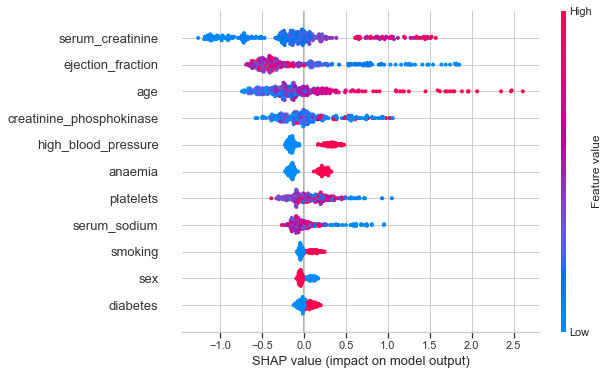

In [81]:
shap.summary_plot(shap_values, X)

#### SHAP Dependence Plots

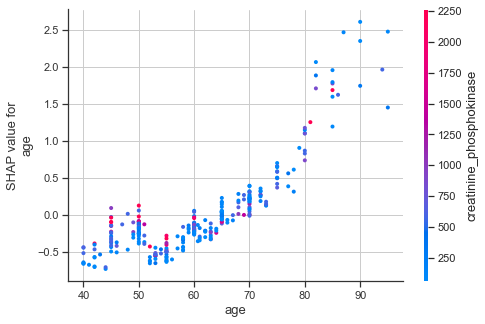

In [82]:
shap.dependence_plot("age", shap_values, X)
# creatinine_phosphokinase is automatically chosen for coloring based on its highest potential for interaction 
# (SHAP interactions heatmap is plotted below)

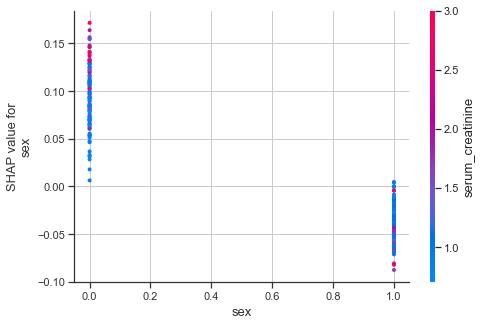

In [83]:
shap.dependence_plot("sex", shap_values, X, display_features=X)

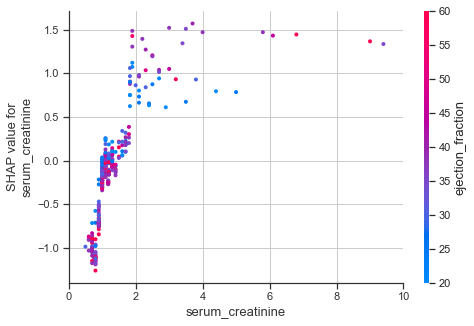

In [84]:
shap.dependence_plot("serum_creatinine", shap_values, X, show=False)  # show=False enables plot cusomization before displaying
pl.xlim(0,10)
pl.show()

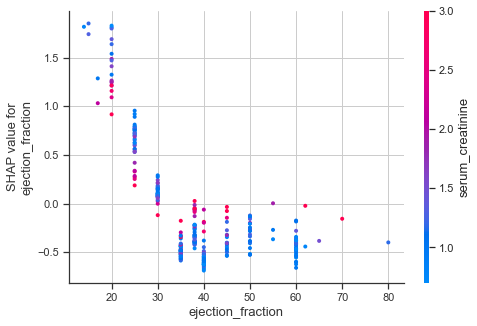

In [85]:
shap.dependence_plot("ejection_fraction", shap_values, X)

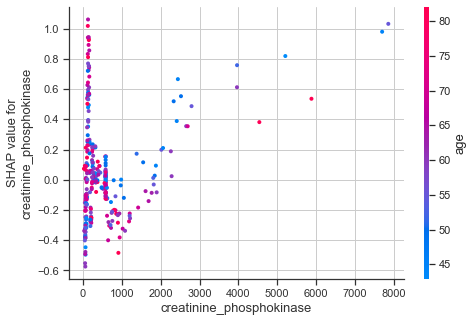

In [86]:
shap.dependence_plot("creatinine_phosphokinase", shap_values, X, display_features=X)

#### Compute SHAP Interaction Values

In [87]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)  # might take few minutes to run

#### SHAP Interaction Value Summary Plot

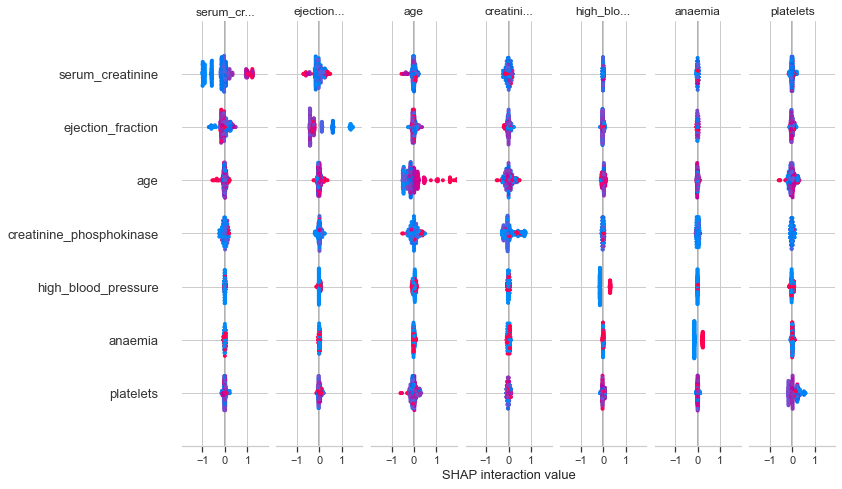

In [88]:
shap.summary_plot(shap_interaction_values, X)

#### SHAP Interaction Value Dependence Plots

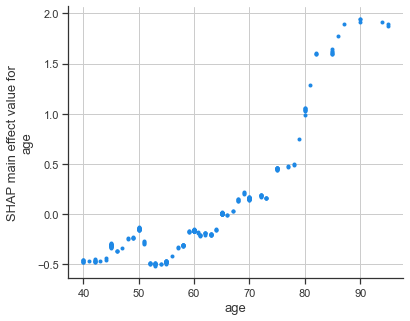

In [89]:
shap.dependence_plot(
    ('age','age'),
    shap_interaction_values, X,
    display_features=X
)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


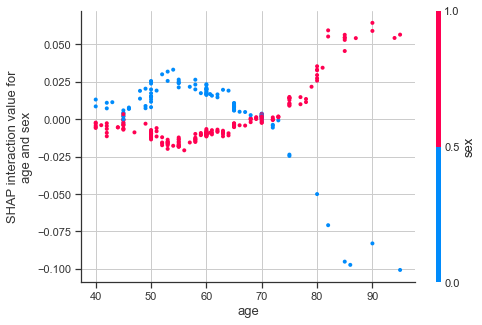

In [90]:
shap.dependence_plot(
    ('age', 'sex'),
    shap_interaction_values, X,
    display_features=X
)

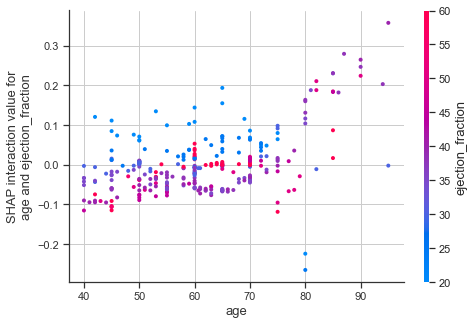

In [91]:
shap.dependence_plot(
    ('age', 'ejection_fraction'),
    shap_interaction_values, X,
    display_features=X
)

In [284]:
# Individual force plot - visualize the impact of each feature on the prediction (output value) for a single observation
# base function is the mean prediction (y-hat) of the entire tested sample
# Red/blue: features that push the prediction to higher/lower values, respectively

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[134:135,:], X.iloc[134:135,:])

#### Plot SHAP interaction values heatmap for every pair of featues

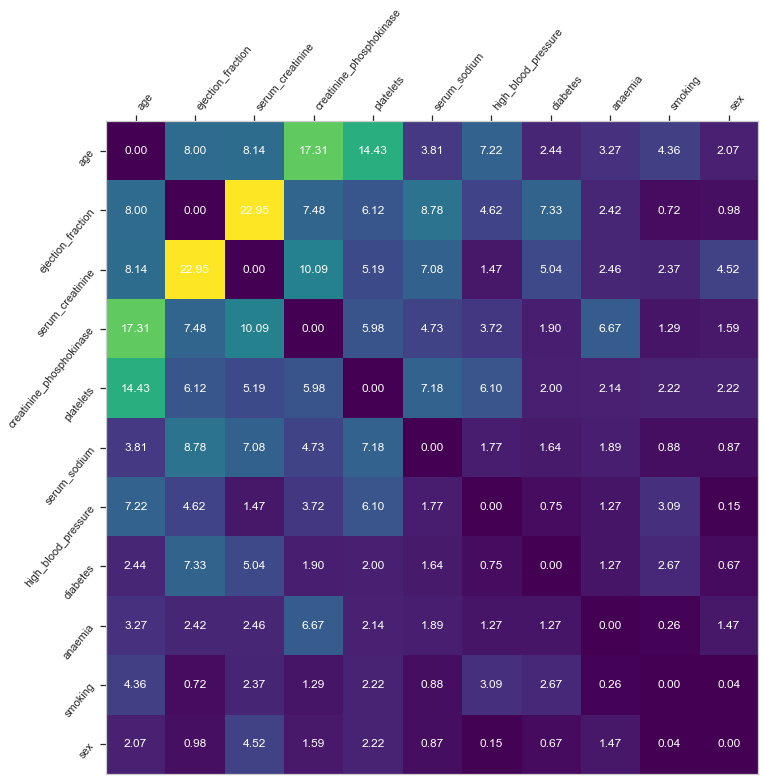

In [94]:
plt.rcParams["axes.grid"] = False
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2, cmap='viridis')
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()

# Loop over data dimensions and create text annotations.
for i in range(len(X.columns[inds])):
    for j in range(len(X.columns[inds])):
        text = pl.text(j, i, '%.2f' % tmp2[i, j],
                       ha="center", va="center", color="w")
pl.show()